In [ ]:
%pip install tweepy
# In IPython (jupyter) 7.3 and later, there is a magic %pip and %conda command that will install into the current kernel
#(rather than into the instance of Python that launched the notebook).

In [ ]:
## For decision trees
# From Anaconda Terminal:
%pip install graphviz
%pip install pydotplus
%conda install graphviz
%conda install pydotplus

In [ ]:
%pip install Unidecode

# <center><ins>Data Preparation</ins></center>

In [1]:
import matplotlib.pyplot as plt
import os
import tweepy           
import pandas as pd     
import numpy as np 

In [2]:
data = pd.read_csv('retweets.csv', sep=",") 
pd.set_option('display.max_columns', None)
print(data.shape)
data.head(3)

(26133, 21)


,origUserId,origUserScreenName,origMepId,origMepName,origMepGroupId,origMepGroupShort,origMepCountryId,origMepCountryShort,retweetUserId,retweetUserScreenName,retweetMepId,retweetMepName,retweetMepGroupId,retweetMepGroupShort,retweetMepCountryId,retweetMepCountryShort,origCreatedAt,origTweetId,retweetCreatedAt,retweetTweetId,lang
0,249601317,papadimoulis,28586,Dimitrios PAPADIMOULIS,0,GUE-NGL,11,GRC,33248043,EvaKaili,125109,Eva KAILI,1,S&D,11,GRC,Tue Nov 01 12:11:39 +0000 2011,131342637201506304,Sat Jun 27 14:17:28 +0000 2015,614799711309012992,el
1,249601317,papadimoulis,28586,Dimitrios PAPADIMOULIS,0,GUE-NGL,11,GRC,33248043,EvaKaili,125109,Eva KAILI,1,S&D,11,GRC,Sun Feb 05 07:45:30 +0000 2012,166064894725206017,Wed Jun 17 12:04:06 +0000 2015,611142270809731072,el
2,217749896,MLP_officiel,28210,Marine LE PEN,7,ENL,9,FRA,498983436,SteeveBriois,124757,Steeve BRIOIS,7,ENL,9,FRA,Sun Mar 25 14:47:16 +0000 2012,183928038675849216,Tue Nov 24 09:58:19 +0000 2015,669092676000686080,fr


In [3]:
data.origMepGroupId.unique()

array([0, 7, 6, 1, 5, 3, 4, 2, 8], dtype=int64)

In [4]:
data.origMepGroupShort.unique()

array(['GUE-NGL', 'ENL', 'EFDD', 'S&D', 'ECR', 'ALDE', 'EPP',
       'Greens-EFA', 'NI'], dtype=object)

In [5]:
# Count distict values, use nunique:
print(data['origTweetId'].nunique())

data.origMepGroupShort.unique()

21041


array(['GUE-NGL', 'ENL', 'EFDD', 'S&D', 'ECR', 'ALDE', 'EPP',
       'Greens-EFA', 'NI'], dtype=object)

### Keep only the records for which the language of the original tweet is in English

In [6]:
data.lang.unique() 

array(['el', 'fr', 'en', 'de', 'pl', 'es', 'sk', 'it', 'sv', 'nl', 'da',
       'pt', 'cy', 'fi', 'ro', 'lt', 'sl', 'und', 'et', 'hr', 'bs', 'no',
       'in', 'hu', 'bg', 'lv', 'uk', 'tl', 'ht', 'ru', 'is', 'cs'],
      dtype=object)

In [7]:
temp3=data.loc[data.lang=='en']
# pd.set_option('display.max_columns', None)
print(temp3.shape)
temp3.head(3)

(13796, 21)


,origUserId,origUserScreenName,origMepId,origMepName,origMepGroupId,origMepGroupShort,origMepCountryId,origMepCountryShort,retweetUserId,retweetUserScreenName,retweetMepId,retweetMepName,retweetMepGroupId,retweetMepGroupShort,retweetMepCountryId,retweetMepCountryShort,origCreatedAt,origTweetId,retweetCreatedAt,retweetTweetId,lang
3,19017675,Nigel_Farage,4525,Nigel FARAGE,6,EFDD,27,GBR,121171051,MargotLJParker,124945,Margot PARKER,6,EFDD,27,GBR,Wed Jul 04 11:05:03 +0000 2012,220473289259233285,Sun Dec 07 21:46:00 +0000 2014,541710240014942209,en
5,17675072,MartinSchulz,1911,Martin SCHULZ,1,S&D,10,DEU,1668992125,NathanGillMEP,124965,Nathan GILL,6,EFDD,27,GBR,Fri Jul 05 08:00:23 +0000 2013,353060776707235841,Thu Jun 18 08:52:51 +0000 2015,611456527409524736,en
11,17675072,MartinSchulz,1911,Martin SCHULZ,1,S&D,10,DEU,21648649,maritaulvskog,96672,Marita ULVSKOG,1,S&D,26,SWE,Sat May 17 12:47:17 +0000 2014,467647542378123264,Wed Sep 16 09:15:06 +0000 2015,644077036022165504,en


# =============================================================

# Get the text of the original tweet 

Our answer was based on the following sites:

   * http://docs.tweepy.org/en/v3.5.0/api.html
   * https://readthedocs.org/projects/tweepy/downloads/pdf/latest/
   * http://docs.tweepy.org/en/v3.5.0/auth_tutorial.html
   * https://stackoverflow.com/questions/44581647/retrieving-a-list-of-tweets-using-tweet-id-in-tweepy

# 1st solution (fast & furious)

<b>api.statuses_lookup</b>: Returns full Tweet objects specified by the id parameter.

Reading the Tweeter API documentation for the statuses_lookup, we found that the limit is 100 tweets per request.
That's why, we decided to divide all the twitter id's in groups of (maximum) size of 100.

We will also use the wait_on_rate_limit and wait_on_rate_limit_notify parameters provided by Tweepy, in order to get the tweet text for all the users, without hitting the rate limits.

<b>Note</b>: Another solution, instead of breaking the data into groups of 100, would be to implement Pagination to iterate through all of the authenticated user's tweets. This could be done via "tweepy.Cursor().pages()" or "tweepy.Cursor().items()".

In [8]:
twitter_ids = temp3.origTweetId
twitter_ids = twitter_ids.to_list()

In [9]:
def tweets(id):
    temp44 = []
    try:
        for i in range(int(len(id)/100) + 1):    # Catch the last group if it is less than 100 tweets
            temp88 = min((i + 1) * 100, len(id))
            temp44.extend(api.statuses_lookup(id_ = id[i * 100:temp88]))
        return temp44
    except tweepy.TweepError:
        print ('TweepError')

### Creating a Twitter App
In order to download tweet text, we need to access to our Twitter account and create an application.
The website to do this is https://apps.twitter.com/.

From this app we will generate the following keys and access tokens:
* Consumer Key
* Consumer Secret
* Access Token
* Access Token Secret

In [10]:
# Variables that contains our credentials to access Twitter API 

consumer_key= 'VaipV9XujcxnoRKYdcUMNyKG8'
consumer_secret= 'uJ9XuvWuBRhz8ZuyUhuFCIwT2mXaVUEA7pjpDIQhzqhhyfe8hE'
access_token =  '717670065047527424-bNu1KaoeN8pcvIKKt5QGj0EFgR0U2jg',
access_token_secret = 'nxoYXhMrbW88a4QFxTMNbDXy9MgQFtVxW8pILDkU3wBCN'

* <b>Connection Settings</b>

To connect to Twitter’s API, we will be using a Python library called Tweepy, 
which is an excellently supported tool for accessing the Twitter API.

In [11]:
import tweepy

#Setup access to API

# Authentication and access using keys:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

# Setting wait_on_rate_limit and wait_on_rate_limit_notify to True makes the API object:
# print a message and wait if the rate limit is exceeded

# Return API with authentication:
api = tweepy.API(auth,wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
kobe24 = tweets(twitter_ids)

In [22]:
pd.set_option('display.max_colwidth', None)  # to display all the text (non-truncated)

status = []
for twitter in kobe24:
    if twitter:
        status.append((twitter.id, twitter.text))

data_text = pd.DataFrame(status, columns=['id','text'])

In [23]:
print(data_text.shape)
data_text.head(3)

(12979, 2)


,id,text
0,220473289259233285,Euro Parliament votes overwhelmingly to reject #ACTA but the Commission say they still intend to press ahead. Another reason to vote @UKIP
1,353060776707235841,"US have one currency, one Central Bank and one Govt. Europe has one currency, one Central Bank and...17 govts! Cannot go on like this."
2,467647542378123264,More jobs for young people is my top priority for the EU @socialdemocraterna @maritaulvskog #EP2014 in Umea Sweden http://t.co/3O6ZM5J8Nt


# --------------------------------------

## 2nd solution (really slow) <font color='red'>(Do not run it!!!)</font>

Due to rate limits it took over 3 hours to run succesfully and the results were the same.

<b>Comment</b>: This solution was presented in order to understand the efficiency of the first solution were.

In [ ]:
status2 = []
for i in range(0,temp3.shape[0]):
    try:
     status2.append((api.get_status(temp3.iloc[i]['origTweetId']).id,api.get_status(temp3.iloc[i]['origTweetId']).text))
    except:
        continue

result2 = pd.DataFrame(status2, columns=['id','text'])

# --------------------------------------

In [24]:
print(data_text.shape)
data_text.head(3)

(12979, 2)


,id,text
0,220473289259233285,Euro Parliament votes overwhelmingly to reject #ACTA but the Commission say they still intend to press ahead. Another reason to vote @UKIP
1,353060776707235841,"US have one currency, one Central Bank and one Govt. Europe has one currency, one Central Bank and...17 govts! Cannot go on like this."
2,467647542378123264,More jobs for young people is my top priority for the EU @socialdemocraterna @maritaulvskog #EP2014 in Umea Sweden http://t.co/3O6ZM5J8Nt


In [25]:
# rename the column, wste basi autis na kanw to join!!
data_text.rename(columns={"id": "origTweetId"}, inplace=True) # inplace=True : rename the existing DataFrame
print(data_text.shape)
data_text.head(3)

(12979, 2)


,origTweetId,text
0,220473289259233285,Euro Parliament votes overwhelmingly to reject #ACTA but the Commission say they still intend to press ahead. Another reason to vote @UKIP
1,353060776707235841,"US have one currency, one Central Bank and one Govt. Europe has one currency, one Central Bank and...17 govts! Cannot go on like this."
2,467647542378123264,More jobs for young people is my top priority for the EU @socialdemocraterna @maritaulvskog #EP2014 in Umea Sweden http://t.co/3O6ZM5J8Nt


In [26]:
print(temp3.shape)
temp3.head(3)

(13796, 21)


,origUserId,origUserScreenName,origMepId,origMepName,origMepGroupId,origMepGroupShort,origMepCountryId,origMepCountryShort,retweetUserId,retweetUserScreenName,retweetMepId,retweetMepName,retweetMepGroupId,retweetMepGroupShort,retweetMepCountryId,retweetMepCountryShort,origCreatedAt,origTweetId,retweetCreatedAt,retweetTweetId,lang
3,19017675,Nigel_Farage,4525,Nigel FARAGE,6,EFDD,27,GBR,121171051,MargotLJParker,124945,Margot PARKER,6,EFDD,27,GBR,Wed Jul 04 11:05:03 +0000 2012,220473289259233285,Sun Dec 07 21:46:00 +0000 2014,541710240014942209,en
5,17675072,MartinSchulz,1911,Martin SCHULZ,1,S&D,10,DEU,1668992125,NathanGillMEP,124965,Nathan GILL,6,EFDD,27,GBR,Fri Jul 05 08:00:23 +0000 2013,353060776707235841,Thu Jun 18 08:52:51 +0000 2015,611456527409524736,en
11,17675072,MartinSchulz,1911,Martin SCHULZ,1,S&D,10,DEU,21648649,maritaulvskog,96672,Marita ULVSKOG,1,S&D,26,SWE,Sat May 17 12:47:17 +0000 2014,467647542378123264,Wed Sep 16 09:15:06 +0000 2015,644077036022165504,en


## Keep only the records for which you were able to download the tweet text.

------------------------------------------------------------------------
## 1st step: Removal of all the duplicate rows for each table
We have duplicate rows of the merge column in the two tables, so if If we currently merge them we'll get k * m rows with that merge column value, where k is the number of rows with that value in data set 1 and m is the number of rows with that value in data set 2. In particular, the merged table with the inner join will have over 21000 rows.

In our analysis we want to see in which class every value belongs, so we do not need the duplicate rows. We will remove the duplicate rows before joining the two tables for performance reasons, because if we removed the duplicates after the join it would be computationally more expensive.

In [27]:
print(temp3.shape,"\t","\t",data_text.shape)

(13796, 21) 	 	 (12979, 2)


In [28]:
print(temp3[['origMepGroupShort','origTweetId']].duplicated().any()) # True
print('Number of duplicate rows in the data:',temp3.duplicated(subset=['origMepGroupShort','origTweetId'], keep='first').sum())

True
Number of duplicate rows in the data: 2962


In [29]:
import pandas as pd

print(temp3.shape)
# first : Drop duplicates except for the first occurrence.
temp3_new = temp3.drop_duplicates(subset=['origMepGroupShort','origTweetId'], keep='first')
print(temp3_new.shape)

# subset: column label or sequence of labels, optional
## Only consider certain columns for identifying duplicates, by default use all of the columns.

(13796, 21)
(10834, 21)


In [30]:
print(data_text[['origTweetId','text']].duplicated().any()) # True
print('Number of duplicate rows in data_text table:',data_text.duplicated(subset=['origTweetId', 'text'], keep='first').sum())

True
Number of duplicate rows in data_text table: 2812


In [31]:
import pandas as pd

print(data_text.shape)
# first : Drop duplicates except for the first occurrence.
data_text_new = data_text.drop_duplicates(subset=['origTweetId', 'text'], keep='first')
print(data_text_new.shape)

# subset: column label or sequence of labels, optional
## Only consider certain columns for identifying duplicates, by default use all of the columns.

(12979, 2)
(10167, 2)


## 2nd step: Join
* In order to keep only the records for which we were able to download the tweet text we will use an <b>inner join</b>, based on the id in the dataframe that contains the text

* The INNER JOIN keyword selects records that have matching values in both tables.

In [32]:
data_merged = pd.merge(temp3_new, data_text_new, how='inner', on='origTweetId')
print(data_merged.shape)
data_merged.head(1)

(10167, 22)


,origUserId,origUserScreenName,origMepId,origMepName,origMepGroupId,origMepGroupShort,origMepCountryId,origMepCountryShort,retweetUserId,retweetUserScreenName,retweetMepId,retweetMepName,retweetMepGroupId,retweetMepGroupShort,retweetMepCountryId,retweetMepCountryShort,origCreatedAt,origTweetId,retweetCreatedAt,retweetTweetId,lang,text
0,19017675,Nigel_Farage,4525,Nigel FARAGE,6,EFDD,27,GBR,121171051,MargotLJParker,124945,Margot PARKER,6,EFDD,27,GBR,Wed Jul 04 11:05:03 +0000 2012,220473289259233285,Sun Dec 07 21:46:00 +0000 2014,541710240014942209,en,Euro Parliament votes overwhelmingly to reject #ACTA but the Commission say they still intend to press ahead. Another reason to vote @UKIP


### Keep only the columns from the data we need

In [33]:
# Target variable

print(data_merged['origMepGroupShort'].nunique())
print(data_merged.origMepGroupShort.unique() )

9
['EFDD' 'S&D' 'ECR' 'ALDE' 'EPP' 'Greens-EFA' 'GUE-NGL' 'ENL' 'NI']


In [34]:
data_final = data_merged[['origMepGroupShort','origTweetId', 'text']]
print(data_final.shape)
data_final.head(3)

(10167, 3)


,origMepGroupShort,origTweetId,text
0,EFDD,220473289259233285,Euro Parliament votes overwhelmingly to reject #ACTA but the Commission say they still intend to press ahead. Another reason to vote @UKIP
1,S&D,353060776707235841,"US have one currency, one Central Bank and one Govt. Europe has one currency, one Central Bank and...17 govts! Cannot go on like this."
2,S&D,467647542378123264,More jobs for young people is my top priority for the EU @socialdemocraterna @maritaulvskog #EP2014 in Umea Sweden http://t.co/3O6ZM5J8Nt


### Group the records by the European group of the MEP that posted the original tweet. We only keep the groups with more than 50 tweets

In [35]:
pao_a = data_final.groupby("origMepGroupShort")["origTweetId"].size().reset_index(name='count').sort_values(['count'], ascending=True)
print(pao_a)
pao = data_final.groupby("origMepGroupShort")["origTweetId"].count()
pao13 = pao[pao > 50]
#pao13
pao13.index

  origMepGroupShort  count
7                NI      1
3               ENL     21
5           GUE-NGL    304
6        Greens-EFA    953
1               ECR    966
0              ALDE   1457
4               EPP   1638
8               S&D   2408
2              EFDD   2419


Index(['ALDE', 'ECR', 'EFDD', 'EPP', 'GUE-NGL', 'Greens-EFA', 'S&D'], dtype='object', name='origMepGroupShort')

In [36]:
pao13 = pao[pao > 50]
pao13.sort_values( ascending=True)

origMepGroupShort
GUE-NGL        304
Greens-EFA     953
ECR            966
ALDE          1457
EPP           1638
S&D           2408
EFDD          2419
Name: origTweetId, dtype: int64

In [37]:
print(data_final.shape)

(10167, 3)


In [38]:
# If you have multiple values you want to include, put them in a list (or more generally, any iterable) and use isin

data_final = data_final.loc[data_merged['origMepGroupShort'].isin(pao13.index)]
print(data_final.shape)
data_final.head(3)

(10145, 3)


,origMepGroupShort,origTweetId,text
0,EFDD,220473289259233285,Euro Parliament votes overwhelmingly to reject #ACTA but the Commission say they still intend to press ahead. Another reason to vote @UKIP
1,S&D,353060776707235841,"US have one currency, one Central Bank and one Govt. Europe has one currency, one Central Bank and...17 govts! Cannot go on like this."
2,S&D,467647542378123264,More jobs for young people is my top priority for the EU @socialdemocraterna @maritaulvskog #EP2014 in Umea Sweden http://t.co/3O6ZM5J8Nt


In [39]:
# We do not need anymore the'origTweetId' columns, so we remove it

del data_final['origTweetId']
print(data_final.shape)
data_final.head(3)

(10145, 2)


,origMepGroupShort,text
0,EFDD,Euro Parliament votes overwhelmingly to reject #ACTA but the Commission say they still intend to press ahead. Another reason to vote @UKIP
1,S&D,"US have one currency, one Central Bank and one Govt. Europe has one currency, one Central Bank and...17 govts! Cannot go on like this."
2,S&D,More jobs for young people is my top priority for the EU @socialdemocraterna @maritaulvskog #EP2014 in Umea Sweden http://t.co/3O6ZM5J8Nt


# =============================================================

# <center><ins>Classification</ins></center>

# Label Encoding (for the target variable)
Machine learning models require numeric features and labels to provide a prediction.

We will use the LabelEncoder function from scikit-learn in order to normalize the labels.

In this encoding, each category is assigned a value from 0 through N-1, where N is the number of categories for the feature.

In [40]:
# label encode the target variable 
from sklearn.preprocessing import LabelEncoder
data_final14 = data_final.copy()

data_final14['label_encoded'] = LabelEncoder().fit_transform(data_final14.origMepGroupShort)  
                                                           # or: (data_final14[['origMepGroupShort']])
data_final14.head(5)

,origMepGroupShort,text,label_encoded
0,EFDD,Euro Parliament votes overwhelmingly to reject #ACTA but the Commission say they still intend to press ahead. Another reason to vote @UKIP,2
1,S&D,"US have one currency, one Central Bank and one Govt. Europe has one currency, one Central Bank and...17 govts! Cannot go on like this.",6
2,S&D,More jobs for young people is my top priority for the EU @socialdemocraterna @maritaulvskog #EP2014 in Umea Sweden http://t.co/3O6ZM5J8Nt,6
3,EFDD,"Vote #Labour, get Tory. Vote Tory, get Labour. Vote #UKIP get UKIP http://t.co/buStolPbTT",2
4,ECR,Answering my question in ECR Group J-C Juncker has confirmed that the post of Chief Scientific Advisor will be continued in his presidency.,1


In [41]:
print(data_final14.label_encoded.unique())
print(data_final14.origMepGroupShort.unique())

[2 6 1 0 3 5 4]
['EFDD' 'S&D' 'ECR' 'ALDE' 'EPP' 'Greens-EFA' 'GUE-NGL']


In [42]:
dict2 = pd.Series(data_final14.label_encoded.values,index=data_final14.origMepGroupShort).to_dict()
dict2

{'EFDD': 2,
 'S&D': 6,
 'ECR': 1,
 'ALDE': 0,
 'EPP': 3,
 'Greens-EFA': 5,
 'GUE-NGL': 4}

In [43]:
sort_dict = sorted(dict2.items(), key=lambda x: x[1])
sort_dict

[('ALDE', 0),
 ('ECR', 1),
 ('EFDD', 2),
 ('EPP', 3),
 ('GUE-NGL', 4),
 ('Greens-EFA', 5),
 ('S&D', 6)]

In [44]:
import numpy as np

count42 = np.array(np.unique(data_final14[['origMepGroupShort']], return_counts=True)).T
# count42

In [45]:
target = data_final[['origMepGroupShort']]

count42 = pd.DataFrame(count42)  
count42.rename(columns={0: "Class",1:"Count"}, inplace=True) 
pct = 100*(count42[['Count']]/len(target))
count42[['Percentage']] = pct.astype(float).round(2)
count42

,Class,Count,Percentage
0,ALDE,1457,14.36
1,ECR,966,9.52
2,EFDD,2419,23.84
3,EPP,1638,16.15
4,GUE-NGL,304,3.00
5,Greens-EFA,953,9.39
6,S&D,2408,23.74


In [46]:
import numpy as np

np.array(np.unique(data_final14[['label_encoded']], return_counts=True)).T

array([[   0, 1457],
       [   1,  966],
       [   2, 2419],
       [   3, 1638],
       [   4,  304],
       [   5,  953],
       [   6, 2408]], dtype=int64)

In [47]:
n_classes = len(sort_dict)
print("number_of_classes:", n_classes)

number_of_classes: 7


In [48]:
pd.set_option('display.max_colwidth', None)  # to display all the text (non-truncated)
data_final14 = data_final14[['label_encoded','text']]

data_final = data_final14  # with the label encoded
data_final.head(3)

,label_encoded,text
0,2,Euro Parliament votes overwhelmingly to reject #ACTA but the Commission say they still intend to press ahead. Another reason to vote @UKIP
1,6,"US have one currency, one Central Bank and one Govt. Europe has one currency, one Central Bank and...17 govts! Cannot go on like this."
2,6,More jobs for young people is my top priority for the EU @socialdemocraterna @maritaulvskog #EP2014 in Umea Sweden http://t.co/3O6ZM5J8Nt


# -------------------------------------------------------------------------------------

## Comment for training and test datasets
* One common practice for this kind of split is presented below, where we first shuffle the text data and then split them in training and test sets.

* In our analysis, as will see later, we decided to split in training and test sets based on each matrix created by the different bag of words methods. The fact that we will be using k-fold cross validation and compute the mean accuracy, makes it ok to compare the algorithms using the same size of train and test sets but with some different indices.

In [48]:
import numpy as np
import random

random.seed(1) 
text353 = data_final[['text']]
indices = np.arange(text353.shape[0])  
np.random.shuffle(indices)     

data_shuffle = np.matrix(text353)[indices]
y =data_final[['label_encoded']].iloc[indices] # for the dependent (y variable)

print(len(text353),"\t",np.matrix(text353).shape)

train_rows = round(0.7*data_shuffle.shape[0])

# Create train and test sets.
train = data_shuffle[indices[:train_rows], :]
test = data_shuffle[indices[train_rows:], :]

y_train = y.iloc[indices[:train_rows]]
y_test =  y.iloc[indices[train_rows:]]
train = np.nan_to_num(train)

print(train.shape,"\t","\t","y_train:",y_train.shape)
print(test.shape,"\t","\t","y_test:",y_test.shape)

10145 	 (10145, 1)
(7102, 1) 	 	 y_train: (7102, 1)
(3043, 1) 	 	 y_test: (3043, 1)


# =====================================================

# Text cleaning
Before creating any feature from the raw text, we must perform a cleaning process to ensure no distortions are introduced to the model.

Text cleaning can help to reduce the noise present in text data in the form of stopwords,punctuations marks etc.

By removing these, we can reduce the size of the matrix, and make training an algorithm faster.

The text cleaning we performed was based on the following steps:

* Upcase/lowercase: Example for justification: 'Why' and 'why' are treated as different entities.

* Removal of punctuation signs: e.g. “?”, “!”, “;”. Example for justification: 'use' and 'use.' are treated as different entities.

* Removal of usernames from Twitter tweet

* Removal of URL links from Twitter tweet

* Removal of special character cleaning: any non-letter, space, or digit character such as “\n”

* Removal of the stopwords: words such as “what” or “the”

* Strip accents

* Replace sequences of whitespace with a space character

For more information check the following sites:

Special characters: https://linuxconfig.org/list-of-python-escape-sequence-characters-with-examples

Punctuation:        https://grammar.yourdictionary.com/punctuation/what/fourteen-punctuation-marks.html

English stopwords:  https://countwordsfree.com/stopwords

# Text representation (Bag of Words methods)
If we want to perform any task on the tweet text data using statistical techniques, we can NOT do so since statistical techniques work only with numbers. 
Therefore we need to convert these text sentences into numbers.

In order to represent our text, we will transform the raw text data into feature vectors and new features will be created using the existing dataset. Every row of the dataset will be a single document and the columns (features) will be different depending of which feature creation method we choose.

We will implement the following methods in order to obtain relevant features from our dataset:

1) Bag of word matrix

2) TF-IDF Vectors 
  * a] Word level
  * b] N-Gram level
  * c] Character level

# Bag of word matrix
A bag of word matrix gives us a numerical representation of which words are in which headlines. With this method, every column is a term from the tweet text and every cell represents the frequency count of each term in each document.

## Understanding of the method:
We will first implement the method to all the data without performing any text cleaning, for better understanding.

## 1st way (really slow) => without sckit learn  <font color='green'>(Suggestion: Do not run it)</font>

In [ ]:
# Find all the unique words in the tweet text

from collections import Counter

def make_matrix(headlines, vocab):
    matrix = []
    for headline in headlines:
        #   ## Counter: A Counter is a container that keeps track of how many times equivalent values are added.
        # Count each word in the headline, and make a dictionary.
        counter = Counter(headline.split())  # split, wste na diabazei words,oxi letters!!!!! SOS!!!!!
        
        # Turn the dictionary into a matrix row using the vocab.
        row = [counter.get(w, 0) for w in vocab]
        # The dictionary get() method allows for a default as the second argument, if the key doesn't exist.
        # So counts.get(w,0) gives you 0 if w doesn't exist in counts
        
        matrix.append(row)
    df = pd.DataFrame(matrix)
    df.columns = unique_words
    return df

pin2 = make_matrix(data_final.text, unique_words)

# pin2.to_csv (r'C:\...\bag_of_word.csv', index = False, header=True)
# pin2 = pd.read_csv('bag_of_word.csv', sep=",")  
print(pin2.shape)  # (21036, 36998)
pin2.head(3)

## 2nd way (much faster) => with sckit learn

In [49]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

matrix = vectorizer.fit_transform(data_final.text)

#print(vectorizer.get_feature_names())

matrix = matrix.toarray()
print(matrix)

# print(matrix.toarray())  # 1os tropos
# print(matrix.todense()) # 2os tropos

print(matrix.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(10145, 22874)


## Comment: We have 22874 columns => too many!!

# --------------------------------------------------------

## <center><ins>Start of Text Cleaning</ins></center>

## 1st way: step by step, without any function (slow implementation)
<b>Comment:</b> This way is presented for better understanding.

In [30]:
import nltk
# nltk.download('stopwords')

from nltk.corpus import stopwords

stop_words = set(stopwords.words('english')) 
# stop_words # ola lower case einai

In [32]:
print(len(data_final.text))
range(len(data_final.text))

10145


range(0, 10145)

In [31]:
#---------------------------------------------------------------------------------------
import re

# Lowercase
cleaned_text = [h.lower() for h in data_final.text] 

## remove usernames from twitter data
####### r'\s+'
##  @ matches the character @ literally (case sensitive)
##  Match a single character not present in the list below [^\s]+
##  \s matches any whitespace character (equal to [\r\n\t\f\v ])
##  + Quantifier — Matches between one and unlimited times, as many times as possible, giving back as needed (greedy)

cleaned_text = [re.sub(r'@[^\s]+','', h) for h in cleaned_text] 


## remove URL links from Twitter tweet
cleaned_text = [re.sub(r'http\S+','', h) for h in cleaned_text] 


### http\S+
# http matches the characters http literally 
# \S+ matches any non-whitespace character  (the end of the url)
# + Quantifier — Matches between one and unlimited times, as many times as possible.
# We replace with the empty string!!!


# Replace any non-letter, space, or digit character in the headlines.
## remove all special characters, punctuation and spaces from a string so that I only have letters and numbers.

cleaned_text = [re.sub(r'\W+',' ',h) for h in cleaned_text]  ## \W matches any non-word character (equal to [^a-zA-Z0-9_])
 
cleaned_text = [re.sub(r'\d+','',h) for h in cleaned_text]  ## \d matches a digit (equal to [0-9])

# Replace sequences of whitespace with a space character.
# cleaned_text = [re.sub(r'\s',' ', h) for h in cleaned_text]
cleaned_text = [re.sub(r'\s+',' ', h) for h in cleaned_text]  ## \s matches any whitespace character (equal to [\r\n\t\f\v ])
   ## 1 space mono, oxi parapanw -> gia osa afaire8ikan auto sto telos!!!


#######  r'\s+'
# r'   matches the characters r' literally (case sensitive)
# \s+  matches any whitespace character (equal to [\r\n\t\f\v ])
#  +   Quantifier — Matches between one and unlimited times, as many times as possible,
    
    ## sos: bazw \s+ kai oxi \s sketo giati: 
    # \s+ matches any whitespace character (equal to [\r\n\t\f\v ])
    # + Quantifier — Matches between one and unlimited times, as many times as possible,

    
## Remove the stopwords
# # set: krataw ta unique
stop_words = set(stopwords.words('english'))  ## ola lower case einai, opote den kanw kati
cleaned_text = [h for h in cleaned_text if h not in stop_words]
# stopwords = [re.sub(r'[^wsd]','',s) for s in stopwords]  # 2os tropos (with regex to remove a stopword)
    # wsd matches a single character in the list wsd (case sensitive)

In [35]:
from collections import Counter

list5 = list(cleaned_text[0:4])
for headline in list5:
    # Count each word in the headline, and make a dictionary.
    counter = Counter(headline.split())
counter

Counter({'vote': 3, 'labour': 2, 'get': 3, 'tory': 2, 'ukip': 2})

In [32]:
unique_words = list(set(" ".join(cleaned_text).split(" ")))
unique_words[0:6]

['', 'reppublica', 'marrakesh', 'transition', 'setters', 'russian']

In [33]:
# remove the FIRST item from the list where its value is equal to the specified value with
unique_words.remove('')
unique_words[0:6]

['reppublica', 'marrakesh', 'transition', 'setters', 'russian', 'merry']

### Note:
The following table is presented just as example for clearer understanding. <font color='red'> (<b>Run it only if:</font></b> you have already run the 1st way of creating bag of word matrix without using sckit learn)

In [73]:
unique_words = list(set(' '.join(cleaned_text).split(' ')))
unique_words.remove('')

# We've reduced the number of columns in the matrix a bit.
pin13 = make_matrix(cleaned_text, unique_words)

print(pin13.shape)
pin13.head(3)

(10145, 13786)


,jamesons,stakes,shepherd,heartless,iter,consultation,marietje,para,weakened,doing,header,silva,concrete,fortune,stopstoning,prioirties,practical,assured,anyone,curtain,freepalestine,original,democracy,brown,societies,machinery,ability,peterhead,criminalize,lower,abolishment,summed,trilogue,banned,footage,holds,howards,damaging,interviewee,opportunist,nkxt,signlanguages,rammed,loose,glezos,rdc,desperation,falsely,forming,disdain,decide,portfolio,ports,enabling,delegation,colour,get,landrover,oversight,slaves,sociable,oversupply,frontbenches,safety,know,however,away,flynn,commended,sanita,regulators,tents,website,raped,libdem,minimum,heywood,lotta,programs,deficits,apply,forthemany,designated,predicated,abiding,won,magazine,christopher,eradicated,looms,yseef,satisfied,knocks,leads,foster,improper,activists,taxcrimes,hike,florenz,increased,splash,mstämma,wonders,sheer,greenpartyconference,include,deepest,diseases,blockages,jean,auditioning,prolonging,euconomics,navel,that,refusing,accepted,refer,smart,teas,starazagora,highlights,ssm,battle,brusells,monitored,patronising,collaboration,mercury,reactionary,saynotoeu,pity,hypocrite,vocal,sw,kaczynski,humanitarianaid,molenbeek,swe,rleft,worry,dictators,pescongress,buiochas,welfare,democracies,congats,subs,freenimr,whiteribbon,conservation,loony,asia,loses,debunking,echoed,ukeconomy,childnotice,shaking,aids,tikvenik,beeweek,remarkably,traffickers,uup,journal,ger,climaterefugees,rutte,islamists,rapportuer,recognized,increasing,cooker,logo,brierley,lying,trigger,beijing,liberationday,change,deceiving,invested,chairmen,premier,methodist,postponed,prisons,bloodshed,furthest,finishes,minorities,alla,channels,explosion,jaysus,aid,compassionate,abokatuaklibre,arctic,mustang,academic,digitaldensity,infos,mythbustmonday,implementing,fun,debacle,bicycles,shut,cheers,detailed,agus,joshua,europ,sarah,screengrab,aqchallenge,extra,ccps,absurd,clarifications,secutity,offices,rural,franstimmermans,mostly,mainstreaming,dunn,easo,labourinforbritain,toghether,iddr,racket,brackets,egyptian,annually,civilian,duplicate,ibrahimhalawa,prix,drugpolicy,slept,accordance,help,risolution,javed,misuse,expressed,stream,cites,belated,pirinski,wore,nasa,unconditionally,explainer,worlddownsyndromeday,partito,graccident,hurdle,solitary,mental,facto,league,succeed,bbcnews,idpwd,apology,isis,balticpower,tracker,ziemlich,dragons,ages,amazing,courtain,californian,yet,sleight,mentioning,simple,following,encypted,extremely,cecilthelion,aims,gmo,counterfeight,spaindecides,deport,lowing,beggar,requirement,colliery,tejerina,effective,dad,reserves,vps,chulainn,carlisle,crackdown,tolls,fairest,alexis,arrests,socialdemocrats,dictatorship,dayton,voicing,inauguration,rebels,mowlam,μore,mexico,hearing,shona,mcaulay,gildernew,teenager,attended,vanish,morning,euarmy,jihadist,caved,astonishingly,google,personally,skilledtosucceed,deemed,probable,interventions,diminish,kamall,opposing,kick,proice,jihadism,christmas,spouting,leaveeu,royal,go,devolve,myquestion,internsday,dugin,doors,lllweek,form,identical,belg,contributors,statements,typhon,bangladeshi,execute,rational,mw,greenvehicles,prioritised,evidently,foot,guardian,mep,prosperous,lukacijewska,extending,institutions,forked,cfpreality,drowned,hearts,hitchens,rubber,sturgeon,chances,secured,classification,keiser,limitations,press,dish,closes,patrol,fortunately,fusion,shout,indirectly,malaria,myself,hordes,finns,norwegians,roud,wikipedia,behalf,ibrc,engine,songs,ebf,cornelia,will,hrweekend,ottawans,plenarysession,machine,fines,seed,michigan,parisagreement,tearupterror,reached,accident,pattodistabilita,shannon,katowice,coffers,enquiries,ladbrokes,italia,schedule,tones,concern,academia,dissapoinment,initiating,opposed,itco,comi,bloody,fairplay,undeclared,abolished,survivor,economic,elstree,taboo,posh,completes,zeller,survation,contraception,activist,immensely,fellowship,lawson,brainstorming,defectors,ve,eudk,pupils,haunt,spectrum,lauding,aided,summit,westernbalkans,amused,fans,old,reckon,

### Interpretation of the table above:
In the above matrix, you can see in each row the numeric representation of the corresponding sentence. 

For instance, the first row shows the numeric representation of Sentence 1. 
In this row, the word "overwhelmingly" occurs once, therefore we added 1 in the first column. 

The word in the second column is "stakes", it doesn't occur in the first sentence, therefore we added a 0 in the second column for sentence 1. 

This numeric representation can now be used as input to the statistical models.

## Comment: We now have 13786 columns, instead of 22874.

# ----------------------------------------------------------

## 2nd way (much faster) => with sckit learn

In order to not have to code everything out manually every time, we’ll use scikit-learn to construct the bag of words matrices.

Strip accents: We will use the "unicode" method.
* ‘ascii’ is a fast method that only works on characters that have an direct ASCII mapping.
* ‘unicode’ is a slightly slower method that works on any characters. 

In [50]:
from sklearn.feature_extraction.text import CountVectorizer

# Construct a bag of words matrix.
# This will lowercase everything, and ignore all punctuation by default.
# It will also remove stop words.
vectorizer = CountVectorizer(strip_accents='unicode',lowercase=True, stop_words="english")

matrix = vectorizer.fit_transform(cleaned_text)
###### (Transform documents to document-term matrix)

#print(vectorizer.get_feature_names())

######## matrix = pd.DataFrame(matrix.toarray(), columns=vectorizer.get_feature_names())  ############
matrix = matrix.toarray()
print(matrix)
print(matrix.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(10145, 13463)


In [41]:
# number of features.
n_features = matrix.shape[1]
print("number_of_features: ", n_features)

number_of_features:  13463


In [79]:
# Get feature names
feature_names = vectorizer.get_feature_names()

# Create data frame
matrix4 = pd.DataFrame(matrix, columns=feature_names)
print(matrix.shape)
matrix4.iloc[0:3,20:25]

(10145, 13463)


,ability,abject,able,abnormal,aboard
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0


In [81]:
## Find out which column names are not duplicated, and keep them:

print(matrix4.shape)
matrix4 = matrix4.loc[:, ~matrix4.columns.duplicated()]
print(matrix4.shape)

(10145, 13463)
(10145, 13463)


## Comment: We have 320 fewer columns, because we also stripped the accents.

In [83]:
print(data_final.shape,"\t","\t",matrix.shape)

(10145, 2) 	 	 (10145, 13463)


# ======================================
# ======================================
# ======================================

# TF–IDF Vectors
TF-IDF score represents the relative importance of a term in the document and the entire tweet text. TF-IDF score is composed by two terms: the first computes the normalized Term Frequency (TF), the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents divided by the number of documents where the specific term appears.

The TF-IDF value increases proportionally to the number of times a word appears in the document and is offset by the number of documents that contain the word, which helps to adjust for the fact that some words appear more frequently in general.


TF-IDF Vectors can be generated at different levels of input tokens (words, characters, n-grams)

* 1) Word Level TF-IDF : Matrix representing tf-idf scores of every term in different documents

* 2) N-gram Level TF-IDF : N-grams are the combination of N terms together. This Matrix representing tf-idf scores of N-grams

* 3) Character Level TF-IDF : Matrix representing tf-idf scores of character level n-grams in the corpus


## => 1) word level tf-idf

In [35]:
# word level tf-idf

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(analyzer='word',strip_accents='unicode',lowercase=True, stop_words="english")

matrix_tfidf = tfidf_vect.fit_transform(cleaned_text)

matrix_tfidf = matrix_tfidf.toarray()
print(matrix_tfidf)
print(matrix_tfidf.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(10145, 13463)


In [44]:
# xtrain_tfidf.shape   # auto an bale max_feaures =5000

print(matrix_tfidf[0:3,0:3])

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


## => 2) ngram level tf-idf

In [84]:
# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', ngram_range=(1,2),strip_accents='unicode',lowercase=True, stop_words="english", max_features=10000)

### ngram_range=(2,3) => minimum = 2 words, max=3 words

matrix_tfidf_ngram  = tfidf_vect_ngram.fit_transform(cleaned_text)

matrix_tfidf_ngram  = matrix_tfidf_ngram.toarray()
print(matrix_tfidf_ngram)
print(matrix_tfidf_ngram.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(10145, 10000)


### <font color='green'><ins>Note</ins>: Because of the big number of feautures produced, we cannot implement this method using all of them due to memory problems/limitations of our PC.</font>
For example we have almost 82,000 features produced using ngram_range=(1,2) and over 150,000 using ngram_range=(1,3). \
So, we decided to build a vocabulary that only consider the top 10000 features ordered by term frequency across the corpus.

<ins>Comment for ngram_range explanation</ins>:
ngram_range=(a,b) describes the number of words in a row, where a is the minimum and b is the maximum size of ngrams weinclude in the features.
For example, the sentence 'I am Groot' contains the 2-grams 'I am' and 'am Groot'. The sentence is itself a 3-gram.

## => 3) characters level tf-idf

In [53]:
# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', ngram_range=(2,3),strip_accents='unicode',lowercase=True, stop_words="english")

matrix_tfidf_ngram_chars  = tfidf_vect_ngram_chars.fit_transform(cleaned_text)

matrix_tfidf_ngram_chars  = matrix_tfidf_ngram_chars.toarray()
print(matrix_tfidf_ngram_chars)
print(matrix_tfidf_ngram_chars.shape)

[[0.         0.         0.06878136 ... 0.         0.         0.        ]
 [0.         0.         0.03577897 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.07751898 ... 0.         0.         0.        ]
 [0.         0.         0.05015922 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
(10145, 7781)


Number of columns = 7781, because the character level n-grams are fewer!

* strip_accents='ascii' => columns = 7687
* strip_accents='unicode' => columns = 7781

# ============================================================
# ============================================================

# <center>--- <ins>Classification methods</ins> ---</center>


### <ins>Overview of the analysis:</ins>

    1) We will use an example in order to get a grasp of the basic classification analysis
    
    2) We will perform the main classification analysis using different methods

In [47]:
print(data_final.shape)
print("\n",matrix[0:3,20:25])
print("\n",matrix.shape)

(10145, 2)

 [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]

 (10145, 13463)


### *Example of Decision tree (with bag-of-word matrices)*

## Decision Tree Classification
DecisionTreeClassifier is a class capable of performing multi-class classification on a dataset.

As with other classifiers, DecisionTreeClassifier takes as input two arrays: an array X, sparse or dense, of size [n_samples, n_features] holding the training samples, and an array Y of integer values, size [n_samples], holding the class labels for the training samples.

We do not give a max_depth, so nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

## => Shuffle (the data)
In order to be sure that our data are in random order we will shuffle them.

In [54]:
import numpy as np
import random

random.seed(1)  # Set a seed to get the same "random" shuffle every time.
# Shuffle the indices for the matrix.
indices = np.arange(matrix.shape[0])   # dinei tin seira twn rows apo 0,1,2,.... 21034,21035
np.random.shuffle(indices)             ## anakteuw(shuffle) tin seira, wste na einai se tixaia seira

matrix_shuffle = matrix[indices]   # for the matrix (X)
y =data_final[['label_encoded']].iloc[indices] # for the dependent (y variable)

# => Train — test split
We need to set apart a test set in order to prove the quality of our models when predicting unseen data. We have chosen a random split with 70% of the observations composing the training test and 30% of the observations composing the test set. 

We will perform the hyperparameter tuning process with cross validation in the training data, fit the final model to it and then evaluate it in the test set so as to obtain an evaluation metric as less biased as possible, in order to avoid overfitting.

In [91]:
import numpy as np
train_rows = round(0.7*matrix_shuffle.shape[0])

# Create train and test sets.
train = matrix_shuffle[indices[:train_rows], :]
test = matrix_shuffle[indices[train_rows:], :]

y_train = y.iloc[indices[:train_rows]]
y_test =  y.iloc[indices[train_rows:]]
train = np.nan_to_num(train)
# numpy.nan_to_num: 
# Replace NaN with zero and infinity with large finite numbers (default behaviour) or 
# with the numbers defined by the user using the nan, posinf and/or neginf keywords.

In [92]:
print(train.shape,"\t","\t","y_train:",y_train.shape)
print(test.shape,"\t","\t","y_test:",y_test.shape)
# train

(7102, 13463) 	 	 y_train: (7102, 1)
(3043, 13463) 	 	 y_test: (3043, 1)


### 2nd way for train,test split

In [84]:
from sklearn.model_selection import train_test_split 

# Splitting the data into training and testing data   
#####  X_train, X_test, y_train, y_test = train_test_split( matrix_shuffle, y, test_size = 0.3, random_state = 0) 

# random_state = 0)  #san set.seed(0):gia na bgazei ta idia (min allazei ka8e fora)

## Building the Decision Tree

* <b>Note</b>: We will use the gini criterion in the creation of the Decision Tree classifer.

In [93]:
from sklearn.tree import DecisionTreeClassifier

data_tree = DecisionTreeClassifier(max_depth=3)
###  clf_dt = DecisionTreeClassifier(criterion = 'gini', max_depth = 3)

data_tree.fit(train, y_train)
predictions = data_tree.predict(test)
predictions

array([6, 6, 6, ..., 6, 6, 6])

### Draw the Decision tree

We need to install GraphViz and its Python interface, pydotplus.

pydotplus is standard Python, so we can install it via the usual means.

In [97]:
from sklearn import tree

from sklearn.externals.six import StringIO
from IPython.display import Image  

import graphviz
import pydotplus

# call the .exe file in the ipynb via

import os
os.environ["PATH"] += os.pathsep + r'C:\...\Anaconda3\pkgs\graphviz-2.38-hfd603c8_2\Library\bin\graphviz'

In [98]:
## In order to print the names in the decision tree

print(len(feature_names))
feature_names[20:25]

13463


['ability', 'abject', 'able', 'abnormal', 'aboard']

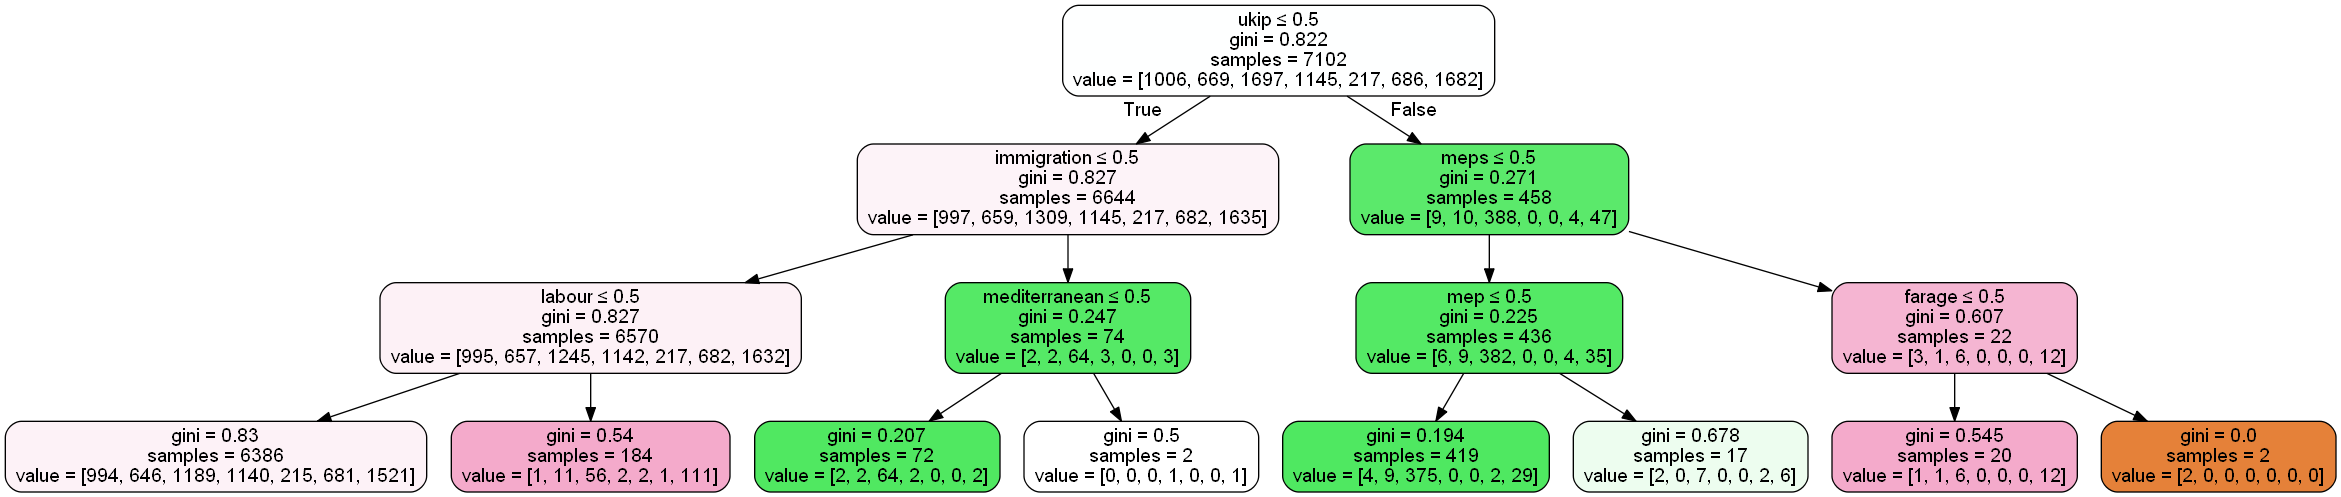

In [99]:
dot_data = StringIO()  
tree.export_graphviz(data_tree, out_file=dot_data, 
                     feature_names=feature_names, 
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())  

## <center>Example of hyperparameter tuning</center>

# Grid Search

One of the tricky things with Machine Learning is knowing which parameter values to use for an estimator.

We can put scikit-learn to do the work for us by using the GridSearchCV class.

The GridSearchCV instance evaluates all the possible combinations of parameter values and retains the best combination.

By default, the parameter search uses the score function of the estimator to evaluate a parameter setting, but we can change that if we want.

The cv parameter gives the number of folds.

The iid parameter, when set to False, will return the average score across folds. When set to True the score is calculated differently (you can check the documentation).

In [88]:
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

parameters = [
  {'max_depth': list(range(1, 11))},
 ]

cv = KFold(n_splits=5, shuffle=True, random_state=13)
clf = GridSearchCV(DecisionTreeClassifier(), parameters, cv=cv, n_jobs = 7)

clf = clf.fit(train, y_train)
print(clf.best_estimator_)
print(clf.best_params_)
print('\nBest max_depth:', clf.best_params_)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
{'max_depth': 10}

Best max_depth: {'max_depth': 10}


In [101]:
from sklearn.tree import DecisionTreeClassifier

# Create Decision Tree classifer object
data_tree = DecisionTreeClassifier(max_depth=10)

# Train Decision Tree Classifer
data_tree.fit(train, y_train)

# Predict the response for test dataset
y_pred = data_tree.predict(test)
y_pred

array([6, 6, 6, ..., 6, 6, 6])

In [91]:
# Alternatively, the probability of each class can be predicted, which is the fraction 
# of training samples of the same classin a leaf.

data_tree.predict_proba(test)

array([[0.16751166, 0.09774894, 0.17724599, ..., 0.03244778, 0.12005678,
        0.22835125],
       [0.16751166, 0.09774894, 0.17724599, ..., 0.03244778, 0.12005678,
        0.22835125],
       [0.00543478, 0.02445652, 0.93206522, ..., 0.        , 0.00543478,
        0.0326087 ],
       ...,
       [0.16751166, 0.09774894, 0.17724599, ..., 0.03244778, 0.12005678,
        0.22835125],
       [0.16751166, 0.09774894, 0.17724599, ..., 0.03244778, 0.12005678,
        0.22835125],
       [0.16751166, 0.09774894, 0.17724599, ..., 0.03244778, 0.12005678,
        0.22835125]])

# Performance Measurement
After performing the hyperparameter tuning process with the training data via cross validation and fitting the model to this training data, we need to evaluate its performance on totally unseen data (the test set). When dealing with classification problems, there are several metrics that can be used to gain insights on how the model is performing. Some of them are:

* Accuracy: the accuracy metric measures the ratio of correct predictions over the total number of instances evaluated.

* Precision: precision is used to measure the positive patterns that are correctly predicted from the total predicted patterns in a positive class.

* Recall: recall is used to measure the fraction of positive patterns that are correctly classified

* F1-Score: this metric represents the harmonic mean between recall and precision values

These metrics are highly extended an widely used in binary classification. However, when dealing with multiclass classification they become more complex to compute and less interpretable. In addition, in this particular application, we just want documents to be correctly predicted. The costs of false positives or false negatives are the same to us.

For this reason, it does not matter to us whether our classifier is more specific or more sensitive, as long as it classifies correctly as much documents as possible. 

Therefore, we have studied the $accuracy$, along with $F1-score$, when comparing models and when choosing the best hyperparameters. 

In the first case, we have calculated the accuracy on both training and test sets so as to detect overfit models. However, we have also obtained the confusion matrix and the classification report (which computes precision, recall and F1-score for all the classes) for every model, so we could further interpret their behavior.

In order to computate some performance measures using the predictions and the values of the target variable in the test sample, we must have the appropriate dimensions.

## 1st step:
 Convert predictions from vector to array with 1 column

In [104]:
predictions = y_pred.reshape(y_pred.shape[0], 1)
print(predictions.shape)
print(predictions.dtype)
# predictions[:5]

(3043, 1)
int32


## 2nd step:
From the dataframe y_test, keep only the values

In [105]:
y_test23 = y_test.values
print(y_test23.shape)
# y_test23

(3043, 1)


### Comment: For better understanding, we will first compute performance meaurues without cross validation

A straightforward performance metric is accuracy: the proportion of instances correctly classified by the classifier.
    
We will check how the classifier does on the test data.
That's the data we held out from the training in the beginning.

### Accuracy - 1st solution

In [106]:
# Model Accuracy, how often is the classifier correct?

# from sklearn import metrics
import sklearn.metrics as metrics

acc = round(metrics.accuracy_score(y_test23, predictions),2)
print("Accuracy:",acc)

Accuracy: 0.33


### Accuracy - 2nd solution

In [107]:
from sklearn.metrics import accuracy_score

accuracy = round(accuracy_score(y_test23, predictions),2)
print("Accuracy:",acc)

Accuracy: 0.33


### f1-score

In [108]:
f1_temp = metrics.f1_score(y_test23, predictions, average='weighted', labels=np.unique(predictions))

print("f1-score:",round(f1_temp,2))

f1-score: 0.3


In [109]:
print(np.unique(y_test23))
print(np.unique(predictions))

[0 1 2 3 4 5 6]
[0 2 3 6]


In [111]:
# Let's see the classification report.

from sklearn.metrics import classification_report

#print(classification_report(y_test, y_pred, target_names=sort_dict))
print(classification_report(y_test23, predictions,zero_division=1))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       451
           1       1.00      0.00      0.00       297
           2       0.71      0.44      0.54       722
           3       0.60      0.05      0.09       493
           4       1.00      0.00      0.00        87
           5       1.00      0.00      0.00       267
           6       0.26      0.90      0.40       726

    accuracy                           0.33      3043
   macro avg       0.65      0.20      0.15      3043
weighted avg       0.54      0.33      0.24      3043



# Confusion Matrix


In [112]:
#  the confusion matrix

from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test23, predictions))
#print(confusion_matrix(y_test23, predictions, labels=range(n_classes)))

# print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test23, predictions))

[[  0   0  12  14   0   0 425]
 [  1   0  37   2   0   0 257]
 [  1   0 316   0   0   0 405]
 [  3   0   8  25   0   0 457]
 [  0   0   1   0   0   0  86]
 [  0   0   2   0   0   0 265]
 [  3   0  69   1   0   0 653]]


# k-fold cross-validation
There is a way to improve the validation of our model, called k-fold cross-validation.

The  𝑘  results from the folds can then be averaged (or otherwise combined) to produce a single estimation.

We will use the "cross_val_score" method to get the validation scores.

The cross_val_score takes a scoring parameter that indicates the score to calculate. It can be one of:
accuracy, recall, f1, etc.

It also takes a cv parameter. When it is an integer, it uses a k-fold strategy.

In [113]:
matrix_shuffle = matrix[indices]   # for the matrix (X)
y =data_final[['label_encoded']].iloc[indices] # for the dependent (y variable)

train_rows = round(0.7*matrix_shuffle.shape[0])

# Create train and test sets.
train = matrix_shuffle[indices[:train_rows], :]
test = matrix_shuffle[indices[train_rows:], :]

y_train = y.iloc[indices[:train_rows]]
y_test =  y.iloc[indices[train_rows:]]
train = np.nan_to_num(train)

In [110]:
from sklearn.tree import DecisionTreeClassifier

# Create Decision Tree classifer object
data_tree = DecisionTreeClassifier(max_depth=10)

# Train Decision Tree Classifer
data_tree.fit(train, y_train)

# Predict the response for test dataset
y_pred = data_tree.predict(test)

# Cross-validation on the training dataset

In [111]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(data_tree, train, y_train, cv=5, scoring='accuracy', n_jobs=7)
scores

array([0.31527094, 0.32653061, 0.32042254, 0.30774648, 0.33098592])

* From here we can obtain the mean and the standard error of the mean (SEM) of the scores.

* In case you don't remember, the SEM is given by:

$$ {\sigma }_{\bar {x}}\ ={\frac {\sigma }{\sqrt {n}}}$$

where $\sigma$ is the standard deviation and $n$ is the size of the population.

In [76]:
from scipy.stats import sem

mesos = round(np.mean(scores),2)
sd = round(sem(scores),4)
print("Mean: ",mesos,"\nStandard error: ", sd)

Mean:  0.32 
Standard error:  0.0028


# ============================================================

# <center>--- <ins>Main Classification Analysis</ins> ---</center>

* After understanding the basics about classification, we will now perform our main analysis using different methods and comparing results. 
* Note: The fact that we are using k-fold cross validation and compute the mean accuracy, makes it ok to compare the algorithms using the same size of train and test sets but with some different values.

## Scoring Parameter:
The available performance metrics used to evaluate a score by cross-validation are presented below:

In [251]:
print(metrics.SCORERS.keys())

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])


For the performance evaluation of the classification algorithms, we decided to use the <b>accuracy</b> metric. 

* The accuracy metric measures the ratio of correct predictions over the total number of instances evaluated.

# <center><font color='green'>1) <ins>Decision trees</ins></font></center>

In order to decide which feature to split on at each step while growing the tree, we used the <b>Gini index</b>. It is an error metric that is designed to show how "pure" a region is.

By “pure” we mean how much of the training data in a particular region belongs to a single class. We grow the tree by selecting at each node the attribute that has the higher value of this metric, which is the one that provides more information for the subscribed variable.

We stop when all the variables have been used or the Gini index is almost equal to zero, thus further breaks will not have any meaning.

## Bag of word matrix


In [79]:
print(matrix.shape)

(10145, 13463)


In [68]:
indices = np.arange(matrix.shape[0])  
np.random.shuffle(indices)          
matrix_shuffle = matrix[indices]  
y =data_final[['label_encoded']].iloc[indices] 
    
train_rows = round(0.7*matrix_shuffle.shape[0])

train = matrix_shuffle[indices[:train_rows], :]
test = matrix_shuffle[indices[train_rows:], :]

y_train = y.iloc[indices[:train_rows]]
y_test =  y.iloc[indices[train_rows:]]
train = np.nan_to_num(train)

In [70]:
# train_split(matrix)

print(train.shape,"\t","\t","y_train:",y_train.shape)
print(test.shape,"\t","\t","y_test:",y_test.shape)
# train

(7102, 13463) 	 	 y_train: (7102, 1)
(3043, 13463) 	 	 y_test: (3043, 1)


In [71]:
from sklearn.tree import DecisionTreeClassifier

# data_tree = DecisionTreeClassifier(max_depth=10)
data_tree = DecisionTreeClassifier()
data_tree.fit(train, y_train)
y_pred = data_tree.predict(test)


predictions = y_pred.reshape(y_pred.shape[0], 1)
y_test23 = y_test.values

In [73]:
from sklearn.model_selection import cross_val_score
from scipy.stats import sem

scores = cross_val_score(data_tree, train, y_train, cv=5, scoring='accuracy', n_jobs=7)

mesos = round(np.mean(scores),3)
sd = round(sem(scores),5)
print("Mean: ",mesos,"\nStandard error: ", sd)

Mean:  0.381 
Standard error:  0.00677


### Comment: By using k-fold cross validaiton the standard error was decreased

# TF–IDF Vectors
## => word level tf-idf

In [84]:
print(matrix_tfidf.shape)

(10145, 13463)


In [75]:
indices = np.arange(matrix_tfidf.shape[0])  
np.random.shuffle(indices)          
matrix_shuffle = matrix_tfidf[indices]  
y =data_final[['label_encoded']].iloc[indices] 
    
    
train_rows = round(0.7*matrix_shuffle.shape[0])

train = matrix_shuffle[indices[:train_rows], :]
test = matrix_shuffle[indices[train_rows:], :]

y_train = y.iloc[indices[:train_rows]]
y_test =  y.iloc[indices[train_rows:]]
train = np.nan_to_num(train)

In [76]:
print(train.shape,"\t","\t","y_train:",y_train.shape)
print(test.shape,"\t","\t","y_test:",y_test.shape)

# data_tree = DecisionTreeClassifier(max_depth=10)
data_tree = DecisionTreeClassifier()
data_tree.fit(train, y_train)
y_pred = data_tree.predict(test)


predictions = y_pred.reshape(y_pred.shape[0], 1)
y_test23 = y_test.values

(7102, 13463) 	 	 y_train: (7102, 1)
(3043, 13463) 	 	 y_test: (3043, 1)


In [77]:
scores = cross_val_score(data_tree, train, y_train, cv=5, scoring='accuracy', n_jobs=7)

mesos1 = round(np.mean(scores),2)
sd1 = round(sem(scores),4)
print("Mean: ",mesos1,"\nStandard error: ", sd1)

Mean:  0.37 
Standard error:  0.0045


# => ngram level tf-idf

In [66]:
print(matrix_tfidf_ngram.shape)

(10145, 10000)


In [67]:
indices = np.arange(matrix_tfidf_ngram.shape[0])  
np.random.shuffle(indices)          
matrix_shuffle = matrix_tfidf_ngram[indices] 
y =data_final[['label_encoded']].iloc[indices] 
    
    
train_rows = round(0.7*matrix_shuffle.shape[0])

train = matrix_shuffle[indices[:train_rows], :]
test = matrix_shuffle[indices[train_rows:], :]

y_train = y.iloc[indices[:train_rows]]
y_test =  y.iloc[indices[train_rows:]]
train = np.nan_to_num(train)

In [ ]:
from sklearn.model_selection import train_test_split 

# Splitting the data into training and testing data   
#####  X_train, X_test, y_train, y_test = train_test_split( matrix_shuffle, y, test_size = 0.3, random_state = 0) 

# random_state = 0)  #san set.seed(0):gia na bgazei ta idia (min allazei ka8e fora)

In [68]:
print(train.shape,"\t","\t","y_train:",y_train.shape)
print(test.shape,"\t","\t","y_test:",y_test.shape)

# data_tree = DecisionTreeClassifier(max_depth=10)
data_tree = DecisionTreeClassifier()
data_tree.fit(train, y_train)
y_pred = data_tree.predict(test)


predictions = y_pred.reshape(y_pred.shape[0], 1)
y_test23 = y_test.values

(7102, 10000) 	 	 y_train: (7102, 1)
(3043, 10000) 	 	 y_test: (3043, 1)


In [69]:
from sklearn.model_selection import cross_val_score
from scipy.stats import sem

scores = cross_val_score(data_tree, train, y_train, cv=5, scoring='accuracy', n_jobs=7)

mesos2 = round(np.mean(scores),2)
sd2 = round(sem(scores),4)
print("Mean: ",mesos2,"\nStandard error: ", sd2)

Mean:  0.37 
Standard error:  0.0063


# => characters level tf-idf

In [91]:
print(matrix_tfidf_ngram_chars.shape)

(10145, 7781)


In [93]:
# train, test, y_train, y_test = train_split(matrix_tfidf_ngram_chars)

In [78]:
indices = np.arange(matrix_tfidf_ngram_chars.shape[0])  
np.random.shuffle(indices)          
matrix_shuffle = matrix_tfidf_ngram_chars[indices]  
y =data_final[['label_encoded']].iloc[indices] 
    
    
train_rows = round(0.7*matrix_shuffle.shape[0])

train = matrix_shuffle[indices[:train_rows], :]
test = matrix_shuffle[indices[train_rows:], :]

y_train = y.iloc[indices[:train_rows]]
y_test =  y.iloc[indices[train_rows:]]
train = np.nan_to_num(train)

In [81]:
print(train.shape,"\t","\t","y_train:",y_train.shape)
print(test.shape,"\t","\t","y_test:",y_test.shape)

# data_tree = DecisionTreeClassifier(max_depth=10)
data_tree = DecisionTreeClassifier()
data_tree.fit(train, y_train)
y_pred = data_tree.predict(test)


predictions = y_pred.reshape(y_pred.shape[0], 1)
y_test23 = y_test.values

(7102, 7781) 	 	 y_train: (7102, 1)
(3043, 7781) 	 	 y_test: (3043, 1)


In [82]:
scores = cross_val_score(data_tree, train, y_train, cv=5, scoring='accuracy', n_jobs=7)

mesos3 = round(np.mean(scores),2)
sd3 = round(sem(scores),4)
print("Mean: ",mesos3,"\nStandard error: ", sd3)

Mean:  0.3 
Standard error:  0.0043


# Conclusion (from comparison):

The mean accuracy was almost the same for all the three methods, but the <b>"word level tf-idf"</b> had the smallest standrard this is the best method for decision trees!!!

# Bagging Model

# <center><font color='green'>2) <ins>Random Forests</ins></font></center>

* Random Forest models are a type of ensemble models, particularly bagging models. They are part of the tree based model family

* As in bagging, we build a number of decision trees on bootstrapped training samples. 

* However, when building these decision trees, each time a split in a tree is considered, a *random sample of 
$m$ predictors* is chosen as split candidates from the full set of $p$ predictors.

* The split is allowed to take place using only these $m$ predictors.

* Usually we pick $m \approx \sqrt{p}$.

* The idea behind random forests is to *decorrelate* the trees.

* If there is a very strong predictor in the data set, then in the collection of bagged trees, all the trees will use that predictor for their top split.

* Therefore all the bagged trees will look similar and the predictions given by the individual trees will be highly correlated.

* However, we want to have uncorrelated quantities to achieve a reduction in variance.

 We are looking for the most discriminative thresholds

In [ ]:
# n_estimators: The number of trees in the forest.(default=100)
# max_depth: The maximum depth of the tree. (default=None)
# min_samples_split: The minimum number of samples required to split an internal node (default=2)

# Bag of word matrix

In [116]:
indices = np.arange(matrix.shape[0])  
np.random.shuffle(indices)          
matrix_shuffle = matrix[indices]  
y =data_final[['label_encoded']].iloc[indices] 
    
    
train_rows = round(0.7*matrix_shuffle.shape[0])

train = matrix_shuffle[indices[:train_rows], :]
test = matrix_shuffle[indices[train_rows:], :]

y_train = y.iloc[indices[:train_rows]]
y_test =  y.iloc[indices[train_rows:]]
train = np.nan_to_num(train)

In [134]:
from sklearn.ensemble import RandomForestClassifier

# forest = RandomForestClassifier(n_estimators=50, max_depth=None, min_samples_split=2, random_state=0)
forest = RandomForestClassifier(random_state=0)
scores = cross_val_score(forest, train, y_train, cv=5, scoring='accuracy', n_jobs=7)
scores
# scores.mean()               

array([0.45320197, 0.47572132, 0.46408451, 0.47464789, 0.45985915])

In [135]:
mesos2a = round(scores.mean(),2)
print("(Random Forest) Mean: ",mesos2a,)
sd2a = round(sem(scores),5)
print("Standard error: ", sd2a)

(Random Forest) Mean:  0.47
Standard error:  0.00432


# TF–IDF Vectors
## => word level tf-idf

In [119]:
indices = np.arange(matrix_tfidf.shape[0])  
np.random.shuffle(indices)          
matrix_shuffle = matrix_tfidf[indices]  
y =data_final[['label_encoded']].iloc[indices] 
    
    
train_rows = round(0.7*matrix_shuffle.shape[0])

train = matrix_shuffle[indices[:train_rows], :]
test = matrix_shuffle[indices[train_rows:], :]

y_train = y.iloc[indices[:train_rows]]
y_test =  y.iloc[indices[train_rows:]]
train = np.nan_to_num(train)

In [120]:
from sklearn.ensemble import RandomForestClassifier

# forest = RandomForestClassifier(n_estimators=50, max_depth=None, min_samples_split=2, random_state=0)
forest = RandomForestClassifier(random_state=0)
scores = cross_val_score(forest, train, y_train, cv=5, scoring='accuracy', n_jobs=7)
# scores
# scores.mean()               

In [121]:
mesos2b = round(scores.mean(),2)
print("(Random Forest) Mean: ",mesos2b,)
sd2b = round(sem(scores),5)
print("Standard error: ", sd2b)

(Random Forest) Mean:  0.46
Standard error:  0.00644


# => ngram level tf-idf

In [70]:
indices = np.arange(matrix_tfidf_ngram.shape[0])  
np.random.shuffle(indices)          
matrix_shuffle = matrix_tfidf_ngram[indices] 
y =data_final[['label_encoded']].iloc[indices] 
    
    
train_rows = round(0.7*matrix_shuffle.shape[0])

train = matrix_shuffle[indices[:train_rows], :]
test = matrix_shuffle[indices[train_rows:], :]

y_train = y.iloc[indices[:train_rows]]
y_test =  y.iloc[indices[train_rows:]]
train = np.nan_to_num(train)

In [71]:
from sklearn.ensemble import RandomForestClassifier

# forest = RandomForestClassifier(n_estimators=50, max_depth=None, min_samples_split=2, random_state=0)
forest = RandomForestClassifier(random_state=0)
scores = cross_val_score(forest, train, y_train, cv=5, scoring='accuracy', n_jobs=7)              

In [72]:
mesos2c = round(scores.mean(),2)
print("(Random Forest) Mean: ",mesos2c,)
sd2c = round(sem(scores),5)
print("Standard error: ", sd2c)

(Random Forest) Mean:  0.46
Standard error:  0.00845


## =>  characters level tf-idf

In [122]:
indices = np.arange(matrix_tfidf_ngram_chars.shape[0])  
np.random.shuffle(indices)          
matrix_shuffle = matrix_tfidf_ngram_chars[indices]  
y =data_final[['label_encoded']].iloc[indices] 
    
    
train_rows = round(0.7*matrix_shuffle.shape[0])

train = matrix_shuffle[indices[:train_rows], :]
test = matrix_shuffle[indices[train_rows:], :]

y_train = y.iloc[indices[:train_rows]]
y_test =  y.iloc[indices[train_rows:]]
train = np.nan_to_num(train)

In [123]:
from sklearn.ensemble import RandomForestClassifier

# forest = RandomForestClassifier(n_estimators=50, max_depth=None, min_samples_split=2, random_state=0)
forest = RandomForestClassifier(random_state=0)
scores = cross_val_score(forest, train, y_train, cv=5, scoring='accuracy', n_jobs=7)              

In [124]:
mesos2c = round(scores.mean(),2)
print("(Random Forest) Mean: ",mesos2c,)
sd2c = round(sem(scores),5)
print("Standard error: ", sd2c)

(Random Forest) Mean:  0.42
Standard error:  0.00396


# Conclusion (from comparison)
<b>"Bag of word"</b>, <b>"word level tf-idf"</b> and <b>"ngram level tf-idf"</b> were the best, but marginally let's say that the <b>"Bag of word"</b> was the best method for Random Forest.

In [129]:
# Bag of words
indices = np.arange(matrix.shape[0])  
np.random.shuffle(indices)          
matrix_shuffle = matrix[indices]  
y =data_final[['label_encoded']].iloc[indices] 
    
    
train_rows = round(0.7*matrix_shuffle.shape[0])

train = matrix_shuffle[indices[:train_rows], :]
test = matrix_shuffle[indices[train_rows:], :]

y_train = y.iloc[indices[:train_rows]]
y_test =  y.iloc[indices[train_rows:]]
train = np.nan_to_num(train)

Improvements such as random forests typically result in improved accuracy over prediction using a single tree. Unfortunately, however, it can be difficult to interpret the resulting model.

Recall that one of the advantages of decision trees is the attractive and easily interpreted tree diagram that can be produced.

However, when we use a set of trees, it is no longer possible to represent the resulting statistical learning procedure using a single tree. It is no longer clear which variables are most important to the procedure.

We can obtain an overall summary of the importance of each predictor in ensemble models using the Gini index (for ensemble classification trees).

* We will present the 10 most important words in our data.

In [136]:
X = train
y = y_train.values.ravel()

forest.fit(train,  y_train.values.ravel())
importances = forest.feature_importances_

std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]   ## Returns the indices that would sort an array.

In [138]:
colnames=vectorizer.get_feature_names() 
colnames[20:25]

['ability', 'abject', 'able', 'abnormal', 'aboard']

In [139]:
imp13 = importances[indices]
yerr13 = std[indices]

names13 = []
for word in range(10):
    names13.append(colnames[indices[word]])

(-1, 10)

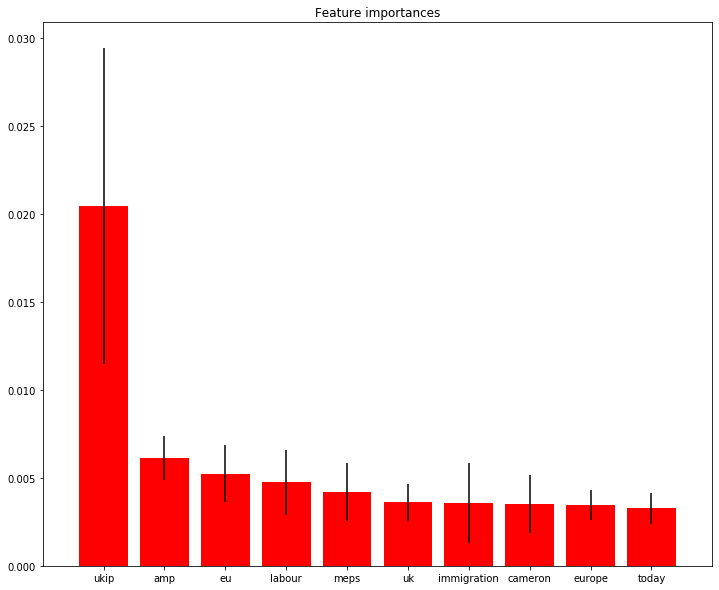

In [136]:
# Plot the feature importances of the forest

plt.figure(figsize=(12, 10))
plt.title("Feature importances")
plt.bar(range(10), imp13[0:10,],
       color="r", yerr=yerr13[0:10,], align="center")
plt.xticks(range(0,10), names13)
plt.xlim([-1, 10])

The most important variables will present the bigger decrease in accuracy upon their removal. That way we can see the variables that mostly influenced the outcome of our prediction. 
In the plot above, we see the importance of each variable used in the implementation of Random Forest. The variables are shown in decreasing order of importance.

So, we observe that the <b>UK Independence Party (UKIP)</b> was found to be the morst important feauture in the Random Forest text classification.

# <center><font color='green'>3) <ins>Boosting</ins></font></center>

* Boosting is another method for improving classification. In fact, it has wider applicability, but we'll consider it here in the context of decision trees. It has been argued that boosting is the best approach to classification trees.

* We'll describe a bit the theory behind two-class classification. Multi-class classification boosting is somewhat more complicated. However, the simple case is a good base for understanding how boosting works.

* The algorithm we'll describe is called "AdaBoost.M1". "AdaBoost" means adaptive boosting.

# Bag of word matrix

In [83]:
indices = np.arange(matrix.shape[0])  
np.random.shuffle(indices)          
matrix_shuffle = matrix[indices]  
y =data_final[['label_encoded']].iloc[indices] 
    
    
train_rows = round(0.7*matrix_shuffle.shape[0])

train = matrix_shuffle[indices[:train_rows], :]
test = matrix_shuffle[indices[train_rows:], :]

y_train = y.iloc[indices[:train_rows]]
y_test =  y.iloc[indices[train_rows:]]
train = np.nan_to_num(train)

In [84]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=100)
scores = cross_val_score(clf, train, y_train, cv=5, scoring='accuracy', n_jobs=7)                         

In [85]:
mesos3a = round(scores.mean(),2)
print("(Ada Boost) Mean: ",mesos3a,) 
sd3a = round(sem(scores),5)
print("Standard error: ", sd3a)

(Ada Boost) Mean:  0.33
Standard error:  0.00203


# => word level tf-idf

In [86]:
indices = np.arange(matrix_tfidf.shape[0])  
np.random.shuffle(indices)          
matrix_shuffle = matrix_tfidf[indices]  
y =data_final[['label_encoded']].iloc[indices] 

train_rows = round(0.7*matrix_shuffle.shape[0])

train = matrix_shuffle[indices[:train_rows], :]
test = matrix_shuffle[indices[train_rows:], :]

y_train = y.iloc[indices[:train_rows]]
y_test =  y.iloc[indices[train_rows:]]
train = np.nan_to_num(train)

In [87]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=100)
scores = cross_val_score(clf, train, y_train, cv=5, scoring='accuracy', n_jobs=7)                         

In [88]:
mesos3b = round(scores.mean(),2)
print("(Ada Boost) Mean: ",mesos3b,) 
sd3b = round(sem(scores),5)
print("Standard error: ", sd3b)

(Ada Boost) Mean:  0.32
Standard error:  0.00438


# => ngram level tf-idf

In [73]:
indices = np.arange(matrix_tfidf_ngram.shape[0])  
np.random.shuffle(indices)          
matrix_shuffle = matrix_tfidf_ngram[indices] 
y =data_final[['label_encoded']].iloc[indices] 
    
    
train_rows = round(0.7*matrix_shuffle.shape[0])

train = matrix_shuffle[indices[:train_rows], :]
test = matrix_shuffle[indices[train_rows:], :]

y_train = y.iloc[indices[:train_rows]]
y_test =  y.iloc[indices[train_rows:]]
train = np.nan_to_num(train)

In [74]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=100)
scores = cross_val_score(clf, train, y_train, cv=5, scoring='accuracy', n_jobs=7)                         

In [75]:
mesos3c = round(scores.mean(),2)
print("(Ada Boost) Mean: ",mesos3c,) 
sd3c = round(sem(scores),5)
print("Standard error: ", sd3c)

(Ada Boost) Mean:  0.33
Standard error:  0.00273


# =>  characters level tf-idf

In [89]:
indices = np.arange(matrix_tfidf_ngram_chars.shape[0])  
np.random.shuffle(indices)          
matrix_shuffle = matrix_tfidf_ngram_chars[indices]  
y =data_final[['label_encoded']].iloc[indices] 
    
    
train_rows = round(0.7*matrix_shuffle.shape[0])

train = matrix_shuffle[indices[:train_rows], :]
test = matrix_shuffle[indices[train_rows:], :]

y_train = y.iloc[indices[:train_rows]]
y_test =  y.iloc[indices[train_rows:]]
train = np.nan_to_num(train)

In [90]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=100)
scores = cross_val_score(clf, train, y_train, cv=5, scoring='accuracy', n_jobs=7)                         

In [91]:
mesos3c = round(scores.mean(),2)
print("(Ada Boost) Mean: ",mesos3c,) 
sd3c = round(sem(scores),5)
print("Standard error: ", sd3c)

(Ada Boost) Mean:  0.33
Standard error:  0.00372


# Conclusion (from comparison):

The mean accuracy was almost the same for all the three methods, but the <b>"Bag of words"</b> had the smallest standrard this is the best method for boosting!!!

# <center><font color='green'>4) <ins>Naive Bayes</ins></font></center>

* Naive Bayes is a classification technique based on Bayes’ Theorem with an assumption of independence among predictors. 

* A Naive Bayes classifier assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature here .


## Multinomial Naive Bayes (Naive Bayes with Multiple Labels)
We will use Multinomial Naive Bayes classification, which is preferable in our case because we want to do multiple class classification, i.e. our target variable has more than two classes.

# Bag of word matrix

In [92]:
indices = np.arange(matrix.shape[0])  
np.random.shuffle(indices)          
matrix_shuffle = matrix[indices]  
y =data_final[['label_encoded']].iloc[indices] 
    
    
train_rows = round(0.7*matrix_shuffle.shape[0])

train = matrix_shuffle[indices[:train_rows], :]
test = matrix_shuffle[indices[train_rows:], :]

y_train = y.iloc[indices[:train_rows]]
y_test =  y.iloc[indices[train_rows:]]
train = np.nan_to_num(train)

In [93]:
#Import Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB

#Create a Multinomial Classifier
naive1 =  MultinomialNB()

y = y_train.values.ravel()

#Train the model using the training sets
naive1.fit(train, y)

#Predict the response for test dataset
y_pred1 = naive1.predict(test)


## Evaluating Model
from sklearn.model_selection import cross_val_score

scores = cross_val_score(naive1, train, y_train, cv=5, scoring='accuracy', n_jobs=7)
# scores

In [94]:
mesos4a = round(scores.mean(),2)
print("NB, Count Vectors - Mean Accuracy: ",mesos4a,) 
sd4a = round(sem(scores),5)
print("Standard error: ", sd4a)

NB, Count Vectors - Mean Accuracy:  0.51
Standard error:  0.00316


# => word level tf-idf

In [95]:
indices = np.arange(matrix_tfidf.shape[0])  
np.random.shuffle(indices)          
matrix_shuffle = matrix_tfidf[indices]  
y =data_final[['label_encoded']].iloc[indices] 
    
train_rows = round(0.7*matrix_shuffle.shape[0])

train = matrix_shuffle[indices[:train_rows], :]
test = matrix_shuffle[indices[train_rows:], :]

y_train = y.iloc[indices[:train_rows]]
y_test =  y.iloc[indices[train_rows:]]
train = np.nan_to_num(train)

In [96]:
#Import Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB

#Create a Multinomial Classifier
naive1 =  MultinomialNB()

y = y_train.values.ravel()

#Train the model using the training sets
naive1.fit(train, y)

#Predict the response for test dataset
y_pred1 = naive1.predict(test)

from sklearn.model_selection import cross_val_score

scores = cross_val_score(naive1, train, y_train, cv=5, scoring='accuracy', n_jobs=7)
# scores

In [97]:
mesos4b = round(scores.mean(),2)
print("NB, Count Vectors - Mean Accuracy: ",mesos4b,) 
sd4b = round(sem(scores),5)
print("Standard error: ", sd4b)

NB, Count Vectors - Mean Accuracy:  0.45
Standard error:  0.00539


# => ngram level tf-idf

In [76]:
indices = np.arange(matrix_tfidf_ngram.shape[0])  
np.random.shuffle(indices)          
matrix_shuffle = matrix_tfidf_ngram[indices] 
y =data_final[['label_encoded']].iloc[indices] 
    
    
train_rows = round(0.7*matrix_shuffle.shape[0])

train = matrix_shuffle[indices[:train_rows], :]
test = matrix_shuffle[indices[train_rows:], :]

y_train = y.iloc[indices[:train_rows]]
y_test =  y.iloc[indices[train_rows:]]
train = np.nan_to_num(train)

In [77]:
#Import Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB

#Create a Multinomial Classifier
naive1 =  MultinomialNB()

y = y_train.values.ravel()

#Train the model using the training sets
naive1.fit(train, y)

#Predict the response for test dataset
y_pred1 = naive1.predict(test)

from sklearn.model_selection import cross_val_score

scores = cross_val_score(naive1, train, y_train, cv=5, scoring='accuracy', n_jobs=7)
# scores

In [78]:
mesos4b = round(scores.mean(),2)
print("NB, Count Vectors - Mean Accuracy: ",mesos4b,) 
sd4b = round(sem(scores),5)
print("Standard error: ", sd4b)

NB, Count Vectors - Mean Accuracy:  0.48
Standard error:  0.00443


# =>  characters level tf-idf

In [98]:
indices = np.arange(matrix_tfidf_ngram_chars.shape[0])  
np.random.shuffle(indices)          
matrix_shuffle = matrix_tfidf_ngram_chars[indices]  
y =data_final[['label_encoded']].iloc[indices] 
    
train_rows = round(0.7*matrix_shuffle.shape[0])

train = matrix_shuffle[indices[:train_rows], :]
test = matrix_shuffle[indices[train_rows:], :]

y_train = y.iloc[indices[:train_rows]]
y_test =  y.iloc[indices[train_rows:]]
train = np.nan_to_num(train)

In [99]:
#Import Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB

#Create a Multinomial Classifier
naive1 =  MultinomialNB()

y = y_train.values.ravel()

#Train the model using the training sets
naive1.fit(train, y)

#Predict the response for test dataset
y_pred1 = naive1.predict(test)

from sklearn.model_selection import cross_val_score

scores = cross_val_score(naive1, train, y_train, cv=5, scoring='accuracy', n_jobs=7)
# scores

In [100]:
mesos4b = round(scores.mean(),2)
print("NB, Count Vectors - Mean Accuracy: ",mesos4b,) 
sd4b = round(sem(scores),5)
print("Standard error: ", sd4b)

NB, Count Vectors - Mean Accuracy:  0.41
Standard error:  0.00127


# Conclusion (from comparison):

<b>"Bag of words"</b> is the best method for Multinomial Naive Bayes!!!

# -------------------------------------------------------

# Gaussian Naive Bayes
In order to be sure that the Multinomial Naive Bayes is the preferable choice for our dataset, we will also implement the Gaussian Naive Bayes, which is usually used for classification with binary labels.

# Bag of word matrix

In [55]:
indices = np.arange(matrix.shape[0])  
np.random.shuffle(indices)          
matrix_shuffle = matrix[indices]  
y =data_final[['label_encoded']].iloc[indices] 
    
    
train_rows = round(0.7*matrix_shuffle.shape[0])

train = matrix_shuffle[indices[:train_rows], :]
test = matrix_shuffle[indices[train_rows:], :]

y_train = y.iloc[indices[:train_rows]]
y_test =  y.iloc[indices[train_rows:]]
train = np.nan_to_num(train)

In [56]:
#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
naive1 =  GaussianNB()

y = y_train.values.ravel()

#Train the model using the training sets
naive1.fit(train, y)

#Predict the response for test dataset
y_pred1 = naive1.predict(test)


## Evaluating Model
from sklearn.model_selection import cross_val_score

scores = cross_val_score(naive1, train, y_train, cv=5, scoring='accuracy', n_jobs=7)
# scores

In [58]:
mesos4a = round(scores.mean(),2)
print("NB, Count Vectors - Mean Accuracy: ",mesos4a,) 
sd4a = round(sem(scores),5)
print("Standard error: ", sd4a)

NB, Count Vectors - Mean Accuracy:  0.39
Standard error:  0.00529


# => word level tf-idf

In [59]:
indices = np.arange(matrix_tfidf.shape[0])  
np.random.shuffle(indices)          
matrix_shuffle = matrix_tfidf[indices]  
y =data_final[['label_encoded']].iloc[indices] 
    
train_rows = round(0.7*matrix_shuffle.shape[0])

train = matrix_shuffle[indices[:train_rows], :]
test = matrix_shuffle[indices[train_rows:], :]

y_train = y.iloc[indices[:train_rows]]
y_test =  y.iloc[indices[train_rows:]]
train = np.nan_to_num(train)

In [61]:
#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
naive2 =  GaussianNB()

y = y_train.values.ravel()

#Train the model using the training sets
naive2.fit(train, y)

#Predict the response for test dataset
y_pred2 = naive2.predict(test)

from sklearn.model_selection import cross_val_score

scores = cross_val_score(naive2, train, y_train, cv=5, scoring='accuracy', n_jobs=7)
# scores

In [61]:
mesos4b = round(scores.mean(),2)
print("NB, Count Vectors - Mean Accuracy: ",mesos4b,) 
sd4b = round(sem(scores),5)
print("Standard error: ", sd4b)

NB, Count Vectors - Mean Accuracy:  0.39
Standard error:  0.00862


# => ngram level tf-idf

In [79]:
indices = np.arange(matrix_tfidf_ngram.shape[0])  
np.random.shuffle(indices)          
matrix_shuffle = matrix_tfidf_ngram[indices] 
y =data_final[['label_encoded']].iloc[indices] 
    
    
train_rows = round(0.7*matrix_shuffle.shape[0])

train = matrix_shuffle[indices[:train_rows], :]
test = matrix_shuffle[indices[train_rows:], :]

y_train = y.iloc[indices[:train_rows]]
y_test =  y.iloc[indices[train_rows:]]
train = np.nan_to_num(train)

In [80]:
#Create a Gaussian Classifier
naive1 =  GaussianNB()

y = y_train.values.ravel()

#Train the model using the training sets
naive1.fit(train, y)

#Predict the response for test dataset
y_pred1 = naive1.predict(test)

from sklearn.model_selection import cross_val_score

scores = cross_val_score(naive1, train, y_train, cv=5, scoring='accuracy', n_jobs=7)
# scores

In [81]:
mesos4b = round(scores.mean(),2)
print("NB, Count Vectors - Mean Accuracy: ",mesos4b,) 
sd4b = round(sem(scores),5)
print("Standard error: ", sd4b)

NB, Count Vectors - Mean Accuracy:  0.45
Standard error:  0.00545


# =>  characters level tf-idf

In [62]:
indices = np.arange(matrix_tfidf_ngram_chars.shape[0])  
np.random.shuffle(indices)          
matrix_shuffle = matrix_tfidf_ngram_chars[indices]  
y =data_final[['label_encoded']].iloc[indices] 
    
train_rows = round(0.7*matrix_shuffle.shape[0])

train = matrix_shuffle[indices[:train_rows], :]
test = matrix_shuffle[indices[train_rows:], :]

y_train = y.iloc[indices[:train_rows]]
y_test =  y.iloc[indices[train_rows:]]
train = np.nan_to_num(train)

In [63]:
#Create a Gaussian Classifier
naive1 =  GaussianNB()

y = y_train.values.ravel()

#Train the model using the training sets
naive1.fit(train, y)

#Predict the response for test dataset
y_pred1 = naive1.predict(test)

from sklearn.model_selection import cross_val_score

scores = cross_val_score(naive1, train, y_train, cv=5, scoring='accuracy', n_jobs=7)
# scores

In [64]:
mesos4b = round(scores.mean(),2)
print("NB, Count Vectors - Mean Accuracy: ",mesos4b,) 
sd4b = round(sem(scores),5)
print("Standard error: ", sd4b)

NB, Count Vectors - Mean Accuracy:  0.31
Standard error:  0.0069


# Conclusion (from comparison):

* We choose <b>"ngram level tf-idf"</b> as the best method for Gaussian Naive Bayes.

* Comment: We also observed that the results in accuracy, were as expected way lower compared to Multinomial Naive Bayes.

# <center><ins>Comparison between all methods</ins></center>

We have tried the following models:
* Decision trees
* Random Forest (Bagging model)
* Boosting Model
* Multinomial Naïve Bayes
* Gaussian Naïve Bayes

In [82]:
meth1 = ['Decision tree (Word level tf-idf)', 'Random Forest (Bag of word matrix)', 'Boosting model (Bag of word matrix)',
         'Multinomial Naïve Bayes (Bag of word matrix)', 'Gaussian Naïve Bayes (ngram level tf-idf)']
meth2 = [.37, .47, .33, .51, .45]
meth3 = [.0045, .0062, .00203, .00316, .00545]
pd.DataFrame({'Classification method':meth1, '(Mean) Accuracy':meth2, '(Mean) Standard Error': meth3})

,Classification method,(Mean) Accuracy,(Mean) Standard Error
0,Decision tree (Word level tf-idf),0.37,0.00450
1,Random Forest (Bag of word matrix),0.47,0.00620
2,Boosting model (Bag of word matrix),0.33,0.00203
3,Multinomial Naïve Bayes (Bag of word matrix),0.51,0.00316
4,Gaussian Naïve Bayes (ngram level tf-idf),0.45,0.00545


* The method with (by far) the best accuracy and with small standard error was: <b> Multinomial Naive Bayes</b>

* We also observed that in Random Forest, Boosting and Multinomial Naive Bayes the <ins>Bag of Words</ins> produced the best results.

* Only in Decision trees, we chose as best the <ins>word level tf-idf</ins> method and it was by a small margin compared to bag of words. Although in Gaussian Naive Bayes <ins>ngram level tf-idf</ins> was found the best method, we must remember that in this method we worked with almost 12% of the data produced.

* The <ins>character level tf-idf</ins> produced the worst results is most cases.

# <center><ins>Hyperparameter tuning</ins></center>

### => for multinomial Naive Bayes (Bag of words method)

In [159]:
indices = np.arange(matrix.shape[0])  
np.random.shuffle(indices)          
matrix_shuffle = matrix[indices]  
y =data_final[['label_encoded']].iloc[indices] 
    
train_rows = round(0.7*matrix_shuffle.shape[0])

train = matrix_shuffle[indices[:train_rows], :]
test = matrix_shuffle[indices[train_rows:], :]

y_train = y.iloc[indices[:train_rows]]
y_test =  y.iloc[indices[train_rows:]]
train = np.nan_to_num(train)

<ins>Hyperparameterts to find:</ins>

    1) alpha
    
    2) fit_prior
    
    3) class_prior

We will perform a Grid Search using 10-Fold Cross Validation 

In [118]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
parameters = {'alpha': alphas, 'fit_prior' : [True, False],'class_prior' : [None, [.1,.9],[.2, .8]] }

naive13 = GridSearchCV(MultinomialNB(), parameters, cv=10, n_jobs = 7)

y13 = y_train.values.ravel()

naive13.fit(train, y13)

GridSearchCV(cv=10, error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=7,
             param_grid={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                   1.0],
                         'class_prior': [None, [0.1, 0.9], [0.2, 0.8]],
                         'fit_prior': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [119]:
print(naive13.best_estimator_)
print("\n",naive13.best_params_)
# print('\nBest max_depth:', naive13.best_params_)

# Single best score achieved across all parameters
#print(round(naive13.best_score_,2))

MultinomialNB(alpha=0.4, class_prior=None, fit_prior=True)

 {'alpha': 0.4, 'class_prior': None, 'fit_prior': True}


* So the best Multinomial Naive Bayes model is the one with:

    1) alpha = 0.4
    
    2) fit_prior = True
    
    3) class_prior = None

# <center><ins>Report the scores (on the test data)</ins></center>

In [234]:
indices = np.arange(matrix.shape[0])  
np.random.shuffle(indices)          
matrix_shuffle = matrix[indices]  
y =data_final[['label_encoded']].iloc[indices] 
    
train_rows = round(0.7*matrix_shuffle.shape[0])

train = matrix_shuffle[indices[:train_rows], :]
test = matrix_shuffle[indices[train_rows:], :]

y_train = y.iloc[indices[:train_rows]]
y_test =  y.iloc[indices[train_rows:]]
train = np.nan_to_num(train)

In [235]:
from sklearn.naive_bayes import MultinomialNB
naive24 =  MultinomialNB(alpha=0.4, class_prior=None, fit_prior=True)

y = y_train.values.ravel()

naive24.fit(train, y)

#Predict the response for test dataset
y_pred24 = naive24.predict(test)

A straightforward performance metric is accuracy: the proportion of instances correctly classified by the classifier.
    
We will check how the classifier does on the test data.
That's the data we held out from the training in the beginning.

In [236]:
# calculate accuracy of class predictions
from sklearn import metrics

acc24 = round(metrics.accuracy_score(y_test, y_pred24),2)
print("Accuracy:",acc24)

Accuracy: 0.55


* So the Multinomial Niave Bayes classifier, classifies correctly about 55% of our test data.

In [ ]:
# The performance with the test data is around 55%.
# So the classifier classifies correctly about 55% of our test data.

## Note that since we partition the training set and the test set in random, the results we get may vary from run to run.

* The $F_1$ score takes both the precision and the recall into account. 

* Mathematically, it is the *harmonic mean* of the precision and the recall.

* We use $F_1$ instead of the standard mean because it punishes extreme values; if either of precision or recall is zero, it will be zero.

In [248]:
f24_temp = metrics.f1_score(y_test, y_pred24, average='weighted', labels=np.unique(y_pred24))
print("f1-score:",round(f24_temp,2))

f1-score: 0.53


In [249]:
## The classification_report function builds a text report showing the main classification metrics. 
# Let's see the classification report.

from sklearn.metrics import classification_report

#print(classification_report(y_test, y_pred, target_names=sort_dict))
print(classification_report(y_test, y_pred24))

              precision    recall  f1-score   support

           0       0.47      0.48      0.48       448
           1       0.44      0.26      0.32       289
           2       0.69      0.80      0.74       735
           3       0.49      0.52      0.50       484
           4       0.48      0.28      0.35        80
           5       0.45      0.28      0.35       288
           6       0.52      0.60      0.56       719

    accuracy                           0.55      3043
   macro avg       0.51      0.46      0.47      3043
weighted avg       0.53      0.55      0.53      3043



### Confusion Matrix

* Another useful metric is the confusion matrix.

* Each cell  (𝑖,𝑗)  in the confusion matrix contains the number of instances of class  𝑖  that were predicted to be in class  𝑗 .

* A good classifier will accumulate values on the diagonal.

In [52]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred24))

[[186  14  24  76   5  24  63]
 [ 23  64  79  35   1   9  64]
 [ 19  33 600  17   5  15  64]
 [ 87  10  21 262   3  14  83]
 [  9   5  13  12  18   9  19]
 [ 59  18  22  40   2  90  64]
 [ 78  37 104  66   3  31 444]]


<ins>Mini intepretation of confusion matrix:</ins>

We saw that the support for the 1st row was equal to 448. After looking at the confusion matrix we understand that from the 448 observations that were 0('ALDE') we correctly identified the 186 of them.


In [53]:
y_pred24_prob = naive24.predict_proba(test)
y_pred24_prob

# calculate AUC
#auc24 = metrics.roc_auc_score(y_test, y_pred24_prob)
#print("AUC:",auc24)

array([[4.52513717e-02, 2.48210533e-01, 4.18510619e-01, ...,
        5.49147019e-02, 5.42453475e-02, 1.30170077e-01],
       [5.85357598e-02, 1.31740497e-02, 1.81689226e-01, ...,
        1.20344926e-01, 1.37713640e-03, 1.30682847e-01],
       [3.48205901e-03, 5.63509583e-05, 6.76856245e-06, ...,
        2.02188942e-09, 1.55716612e-05, 1.50823342e-04],
       ...,
       [6.42453916e-03, 3.84268993e-03, 5.39087924e-05, ...,
        4.35255082e-07, 1.45085326e-02, 7.53850290e-01],
       [2.00711442e-03, 6.06130250e-03, 9.63857543e-01, ...,
        2.55394588e-05, 3.85261050e-03, 2.39878586e-02],
       [9.84436350e-01, 3.67063370e-05, 2.79951073e-07, ...,
        1.87756471e-08, 2.64030696e-05, 1.54521752e-02]])

* We will also calculate the error rate between the predictions on the test set and the actual counts for the test set. 
* Note: In order to perform computations between the predictions and the values of the target variable in the test sample, we must have the appropriate dimensions.

In [ ]:
predictions = y_pred.reshape(y_pred.shape[0], 1)
y_test23 = y_test.values

In [140]:
predictions24 = y_pred24.reshape(y_pred24.shape[0], 1)

In [141]:
# We're going to use mean absolute error as an error metric.
# Our error is about 13.6 upvotes, which means that, on average,
# our prediction is 13.6 upvotes away from the actual number of upvotes.

print(sum(abs(predictions24 - y_test.values)) / len(predictions24))

[1.37430168]


# <center><ins>Baseline classifier</ins></center>
* A way to gauge how the accuracy we obtained is good is to compare it against a *baseline* figure.

* The dummy classifier measures the “baseline” performance — i.e. the success rate one should expect to achieve even if simply guessing.

* It is used only as a simple baseline for the other classifiers — i.e. any other classifier is expected to perform better on the given dataset. 

* So, we will have a floor value for the minimal value one’s classifier should out-perform. As a result we would expect that any analytic approach for a classification problem should be better than a random guessing approach.


<center><ins>Below are a few strategies used by the dummy classifier to predict a class label:</ins></center>

* Most Frequent: The classifier always predicts the most frequent class label in the training set.
    
* Stratified: It generates predictions by respecting the class distribution of the training data. It is different from the “most frequent” strategy as it instead associates a probability with each data point of being the most frequent class label.

* Uniform: It generates predictions uniformly at random.

In [75]:
# strategy: str, default=”stratified”

# random_state: int, RandomState instance or None, optional, default=None
## If int, random_state is the seed used by the random number generator; 
## If RandomState instance, random_state is the random number generator; 
## If None, the random number generator is the RandomState instance used by np.random.

In [54]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt  
import seaborn as sns 

In [55]:
## Training the dummy model

from sklearn.dummy import DummyClassifier

strategies = ['most_frequent', 'stratified', 'uniform'] 
  
test_scores = [] 
for s in strategies: 
    dummy = DummyClassifier(strategy = s, random_state = 0)   #san set.seed(0):gia na bgazei ta idia (min allazei ka8e fora)
    dummy.fit(train, y_train) 
    score = dummy.score(test, y_test) 
    test_scores.append(round(score,2)) 

print(strategies)
test_scores

['most_frequent', 'stratified', 'uniform']


[0.25, 0.17, 0.15]

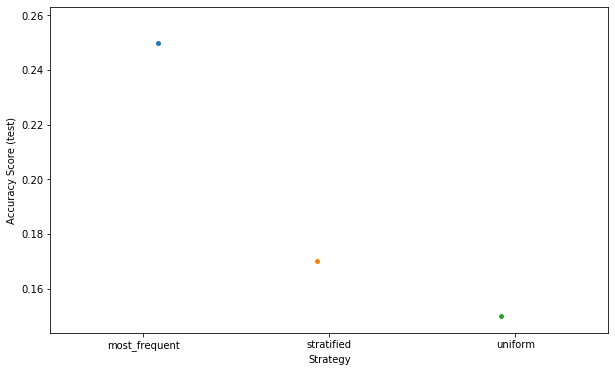

In [56]:
##  Analyzing our results
from matplotlib import pyplot as plt
plt.figure(figsize=(10,6))


ax = sns.stripplot(strategies, test_scores); 
ax.set(xlabel ='Strategy', ylabel ='Accuracy Score (test)') 
plt.show() 

* So the best strategy is the "most frequent"

In [57]:
## Training the dummy model

from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score


dummy = DummyClassifier(strategy = 'most_frequent', random_state = 0) 
dummy.fit(train, y_train) 
predictions_dum = dummy.predict(test)
accuracy_dum = round(accuracy_score(y_test, predictions_dum),2)
print("Accuracy for the baseline classifier:",accuracy_dum)

Accuracy for the baseline classifier: 0.25


In [64]:
f_dum  = metrics.f1_score(y_test, predictions_dum, average='weighted', labels=np.unique(predictions_dum))
print("f1-score for the baseline classifier:",round(f_dum,2))

f1-score for the baseline classifier: 0.4


In [76]:
# from sklearn.metrics import classification_report
# print(classification_report(y_test, predictions_dum,zero_division=1))

In [58]:
from sklearn.dummy import DummyClassifier
import numpy as np

#train a dummy classifier to make predictions based on the most_frequent class value
dummy_classifier = DummyClassifier(strategy="most_frequent")
dummy_classifier.fit(train, y_train) 

#this produces len(test)=3476 predictions that say "2"
for i in test:
    print( dummy_classifier.predict( [i]) )

[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]


[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]


* The "most frequent" strategy produces predictions, which all take the value of "2" (EFDD).

* This is because the classifier always predicts the most frequent class label in the training set

## Comparison of Naive Bayes with the baseline classifier

In [65]:
print("Accuracy:",acc24)
print("f1-score:",round(f24_temp,2))

Accuracy: 0.55
f1-score: 0.54


In [66]:
print("Accuracy for the baseline classifier:",accuracy_dum)
print("f1-score for the baseline classifier:",round(f_dum,2))

Accuracy for the baseline classifier: 0.25
f1-score for the baseline classifier: 0.4


In [73]:
data_final.shape[0]

10145

# <center><ins>Conclusions</ins></center>

* If we selected tweets randomly from our data, we could guess that 1 out 4 of every future tweets will come from the Europe of Freedom and Direct Democracy (EFDD) political group.

* By using the Multinomial Naive Bayes method, we will have better values of the performance measures compared to random guessing (dummy classifier).

* For example the accuracy will be increased by approximately 30%. This means that we will be able to identify the political group of almost 3045 (=10145*0.3) more tweets. 

* We also saw that the performance metrics for this classification algorithm are almost the same (slighlty better) in the test dataset. This reassures us that our model works as expected and generalizes well. 

* <ins>Note</ins>: It is a little strange that these values are so close together (and that we got slighlty better values for the test data than the training data). Usually the performance on the test data is worse than on the training data. 
    * One possible reason is that we found the best hyperparameters and use them to fit the algorithm in the test set.
    * Another reason may be that we got too many features (approx. 7800) for the number of samples (approx. 3000). We may needed to have bigger sample or maybe decrease even more the number of features. 
    * Another reason may be that the 5-fold cross-validation used is not sufficiently precise and it may be necessary to repeat it 100 times to achieve adequate precision. 



* So, we come to the conclusion that the Multinomial Naive Bayes classifier is, in fact, a good classifier for the given data.


## <center><ins>Glossary</ins></center>

<ins>Overfitting:</ins>

Overfitting means that the model is too complex for the data set. It yields a model that matches the model extremely closely, but may be unable to accurately predict what occurs between the data points, because it adds trends to the data set that don’t actually exist. 
Overfitting affects the ability of the model to perform well for unseen data, which is known as a generalization. 


<ins>k-fold cross validation:</ins> 
    
It randomly divides the data into k groups (aka folds) of approximately equal size. The first fold is treated as a validation set and the statistical method is fit on the remaining data. The mean square error, MSE, is then computed on the observations in the held-out fold. This procedure is repeated k times. The k-fold CV estimate is computed by averaging the MSE estimates.
    
<ins>Accuracy:</ins>
    
It determines the overall predicted accuracy of the model. It is the proportion of correct classifications. We care to predict better than pure chance.